### **Variational Physics Informed Neural Network**

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from numpy.polynomial import legendre as leg
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline

In [4]:
def style_plot(x, y, x_data, y_data, yh, i, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations', marker='.', s=6)
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')
        plt.xlabel(r'$x$')
        plt.ylabel(r'$u(x)$')

**Funciones de Test con FEM Helmholtz**

In [5]:
def FEM1D(coords):
    N = len(coords)
    stiff_loc = np.array([[2.0, -2.0],
                          [-2.0, 2.0]])
    mass_loc = np.array([[2/3, 1/3],
                         [1/3, 2/3]])
    eles = [np.array([cont, cont + 1]) for cont in range(0, N - 1)]
    stiff = np.zeros((N, N))
    mass = np.zeros((N, N))
    for ele in eles:  ## Ensamblaje
        jaco = coords[ele[1]] - coords[ele[0]]
        for cont1, row in enumerate(ele):
            for cont2, col in enumerate(ele):
                stiff[row, col] = stiff[row, col] +  stiff_loc[cont1, cont2]/jaco
                mass[row, col] = mass[row, col] +  jaco*mass_loc[cont1, cont2]
    return stiff, mass

# Caso de ejemplo
N = 1000
nvals = 10
x = np.linspace(0, 1, N)

# FEM1D
stiff, mass = FEM1D(x)

# Vectores propios
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

# Interpolación
x_eval = torch.linspace(0, 1, N).detach().numpy()
spline = UnivariateSpline(x, vecs_comp[:, 2], s=0, k=1)
v_eval = spline(x_eval)
v_eval = v_eval.reshape(N, 1)
#
#spline_derivative = spline.derivative()
#v_eval_derivative = spline_derivative(x)

In [6]:
v_test = torch.zeros(N, nvals)
v_dv = torch.zeros(N, nvals)
for i in range(vecs_comp.shape[1]):
    spline_mode = UnivariateSpline(x, vecs_comp[:, i], s=0, k=1)
    v_mode = spline_mode(x)  
    v_mode = v_mode.reshape(N, 1)  
    print(v_mode.shape)

    v_test[:, i] = torch.tensor(v_mode).squeeze()
    v_dv[:, i] = torch.tensor(spline_mode.derivative()(x)).squeeze()

v_test.shape, v_dv.shape

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


(torch.Size([1000, 10]), torch.Size([1000, 10]))

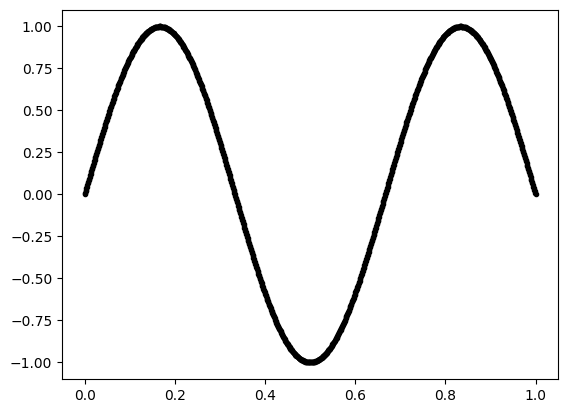

In [7]:
plt.figure()
plt.plot(x, v_eval)
plt.plot(x, v_test[:, 2], ".k")

Text(0.5, 1.0, 'Derivative')

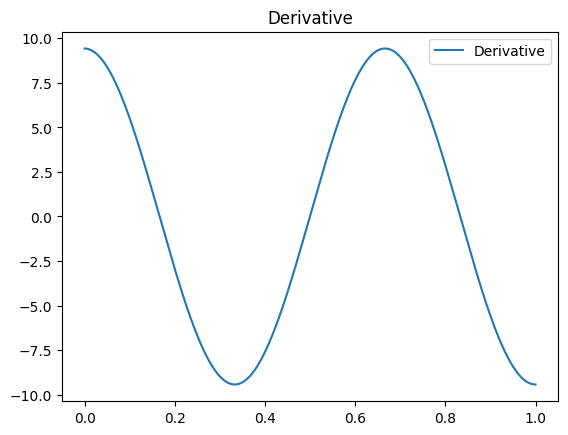

In [8]:
plt.figure()
plt.plot(x, v_dv[:, 2], label='Derivative')
plt.legend()
plt.title('Derivative')

**Arquitectura de Red Neuronal**

In [9]:
class FCN(nn.Module):  
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
                    nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)        
        output = torch.einsum('ij,ij->ij', a, x)
        return output

In [10]:
import torch.nn.functional as F
class CNNPDE(nn.Module):
    def __init__(self):
        super(CNNPDE, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = x.unsqueeze(1)  
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool1d(x, x.size()[2])  
        x = x.permute(0, 2, 1)  
        output = self.fc(x).squeeze(1)
        output = torch.einsum('ij,ij->ij', a, output)
        return output.squeeze(1)  

In [11]:
class RNNPDE(nn.Module):
    def __init__(self):
        super(RNNPDE, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=10, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        a = x * (x - torch.pi)
        x = x.unsqueeze(2)  
        out, _ = self.rnn(x) 
        out = out[:, -1, :]  
        out = self.fc(out) 
        out = torch.einsum('ij,ij->ij', a, out)
        return out.squeeze(1)

In [12]:
class TransformerEDP(nn.Module):    
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(TransformerEDP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, activation='relu'), 
            num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):  
        a = x * (x - torch.pi)      
        x = self.encoder(x)  
        output = self.transformer_encoder(x)  
        output = self.decoder(output)
        out = torch.einsum('ij,ij->ij', a, output)
        return output 

Formulación problema

In [13]:
def f_rhs(x):
  return 4*torch.sin(2 * x) #0.*x-2. #

def exact_u(x):
  return torch.sin(2 * x) #x*(x-torch.pi) #

**Variational Neural Network**

Variational Loss

Loss at iteration 50: 23.416748046875000
Loss at iteration 100: 2.139459609985352
Loss at iteration 150: 1.529289841651917
Loss at iteration 200: 1.395711541175842
Loss at iteration 250: 1.346530795097351
Loss at iteration 300: 1.300046563148499
Loss at iteration 350: 1.245819807052612
Loss at iteration 400: 1.183028221130371
Loss at iteration 450: 1.115057468414307
Loss at iteration 500: 1.049693226814270
Loss at iteration 550: 0.989689648151398
Loss at iteration 600: 0.924655377864838
Loss at iteration 650: 0.839673757553101
Loss at iteration 700: 0.721890389919281
Loss at iteration 750: 0.560044050216675
Loss at iteration 800: 0.368138253688812
Loss at iteration 850: 0.210192903876305
Loss at iteration 900: 0.120077461004257
Loss at iteration 950: 0.074853405356407
Loss at iteration 1000: 0.049725141376257
Loss at iteration 1050: 0.034154430031776


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17912\4069663616.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Loss at iteration 1100: 0.024011198431253
Loss at iteration 1150: 0.017208604142070
Loss at iteration 1200: 0.012550227344036
Loss at iteration 1250: 0.009322152473032
Loss at iteration 1300: 0.007078839000314
Loss at iteration 1350: 0.005526640452445
Loss at iteration 1400: 0.004462081473321
Loss at iteration 1450: 0.003739556064829
Loss at iteration 1500: 0.003253348404542
Loss at iteration 1550: 0.002926792250946
Loss at iteration 1600: 0.002705811755732
Loss at iteration 1650: 0.002552729332820
Loss at iteration 1700: 0.002442604163662
Loss at iteration 1750: 0.002359094796702
Loss at iteration 1800: 0.002291814424098
Loss at iteration 1850: 0.002241266891360
Loss at iteration 1900: 0.002184391487390
Loss at iteration 1950: 0.002137105679139
Loss at iteration 2000: 0.002171458210796
Loss at iteration 2050: 0.002050903160125
Loss at iteration 2100: 0.002008086768910
Loss at iteration 2150: 0.001967093208805
Loss at iteration 2200: 0.001941895810887
Loss at iteration 2250: 0.00188761

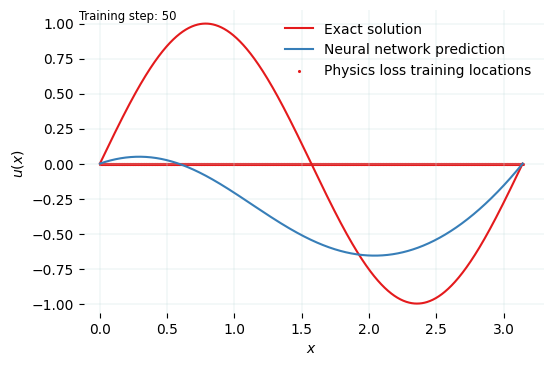

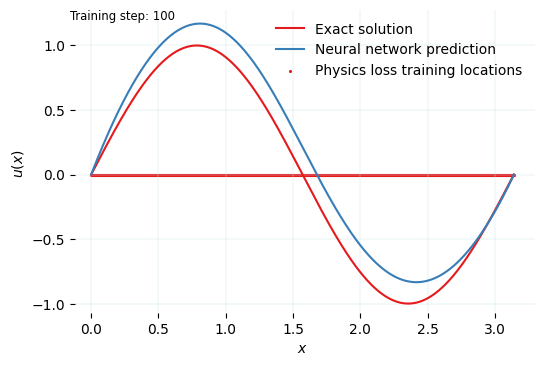

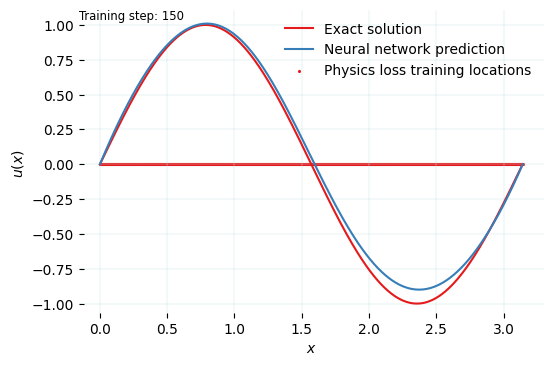

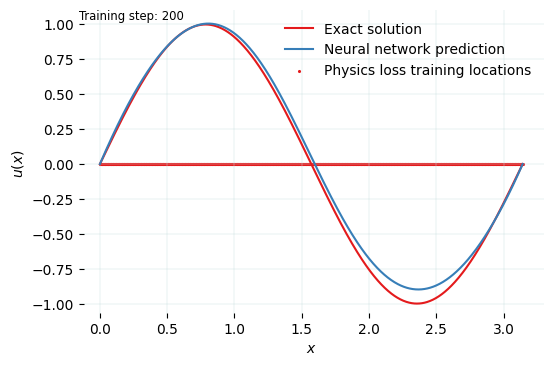

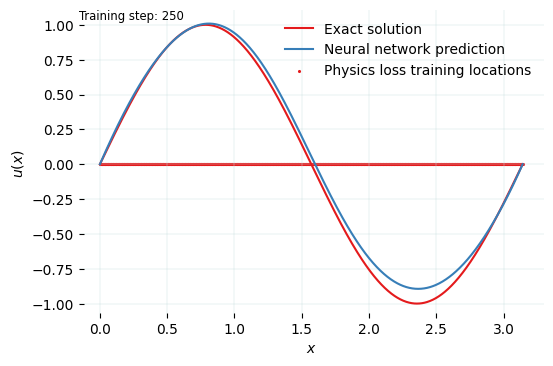

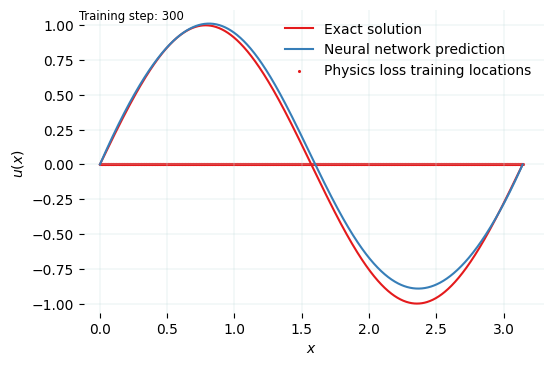

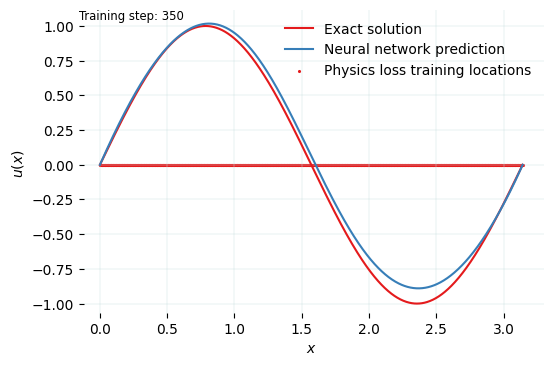

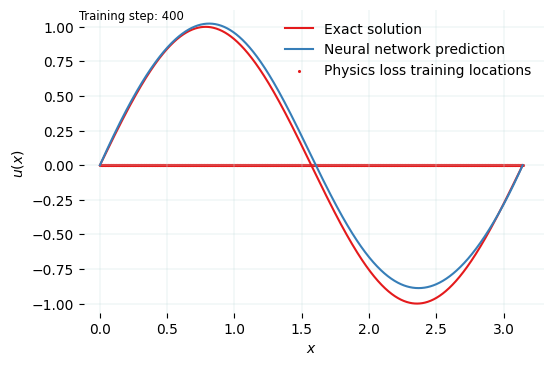

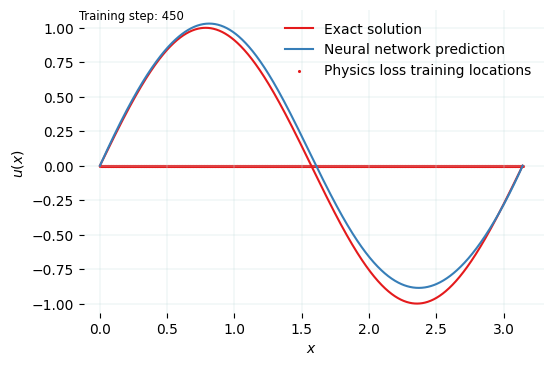

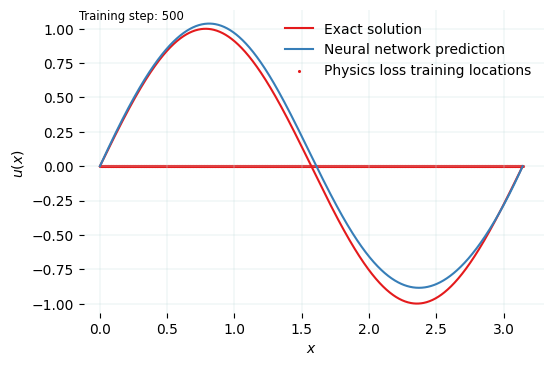

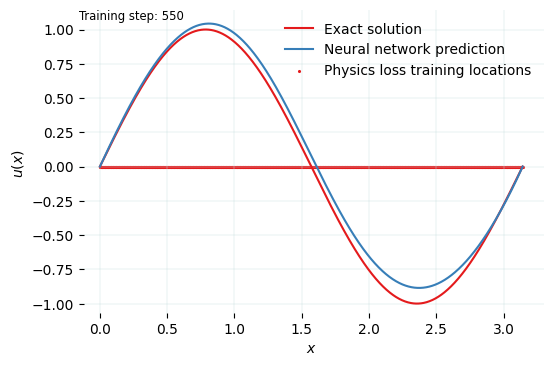

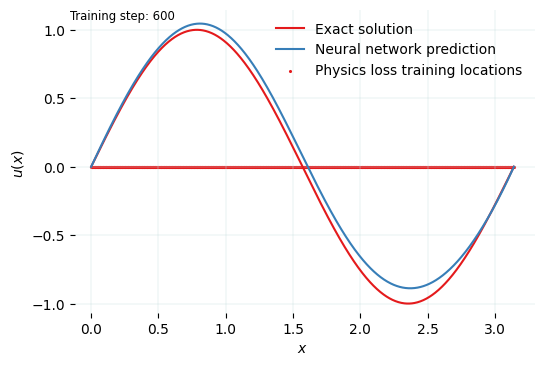

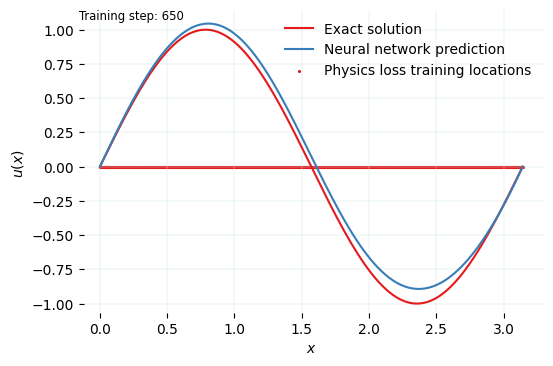

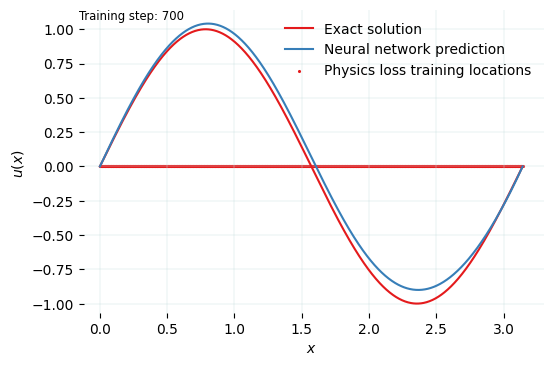

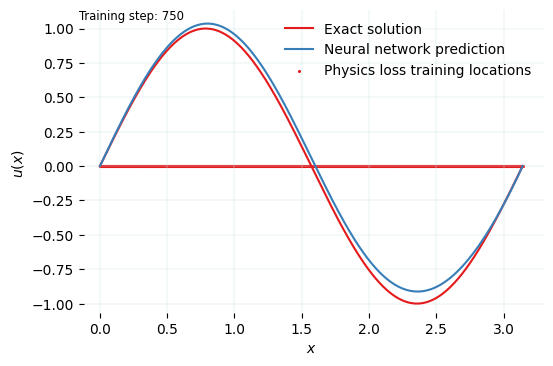

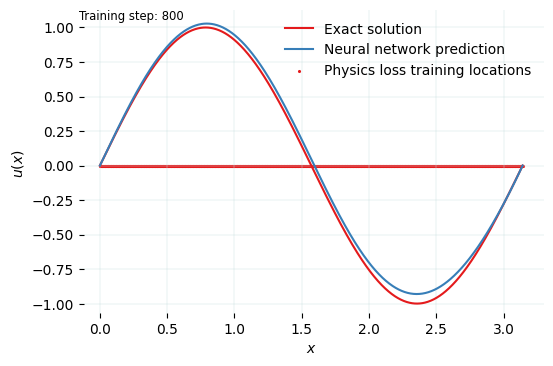

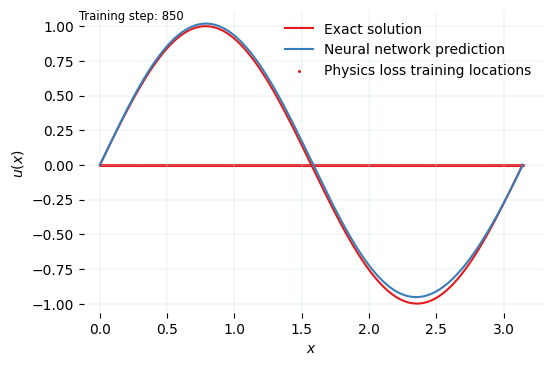

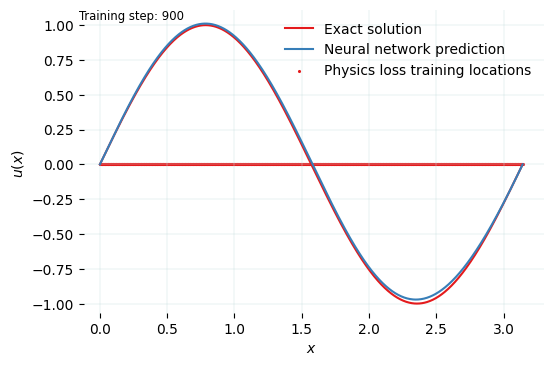

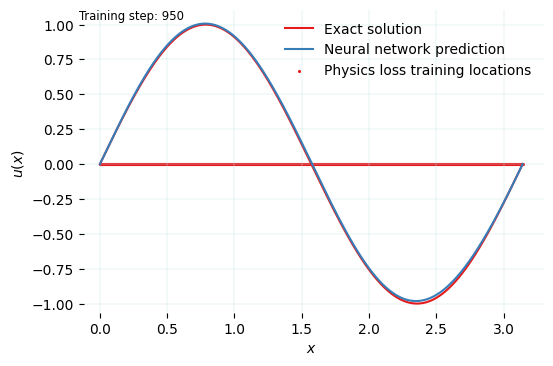

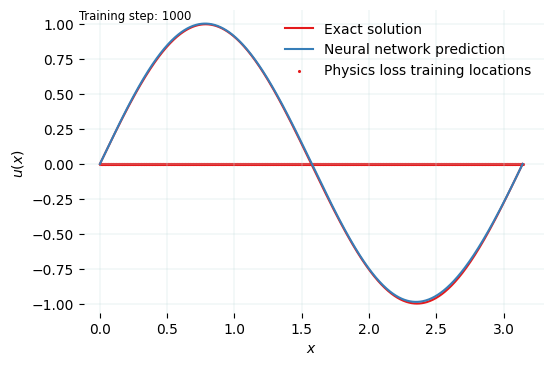

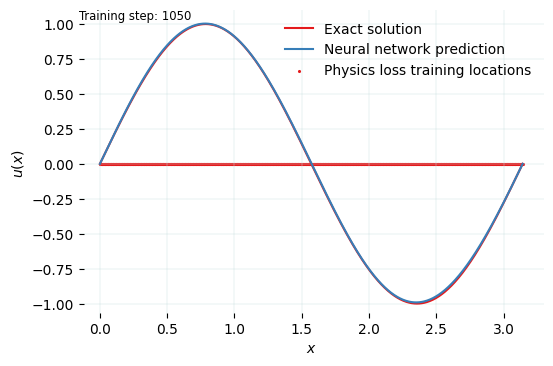

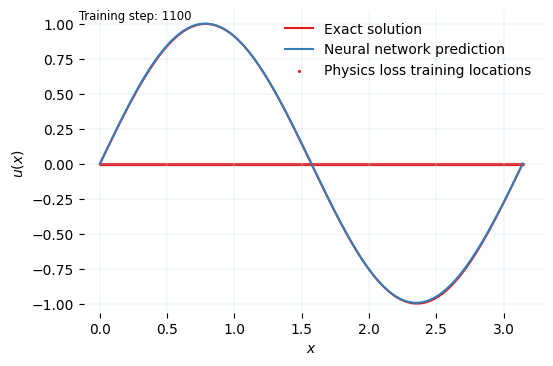

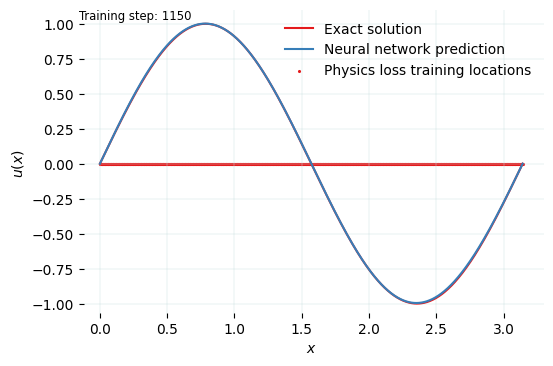

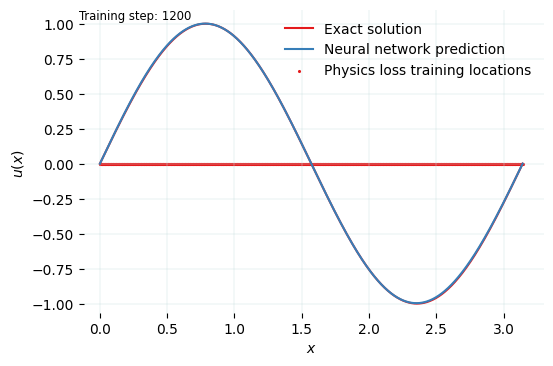

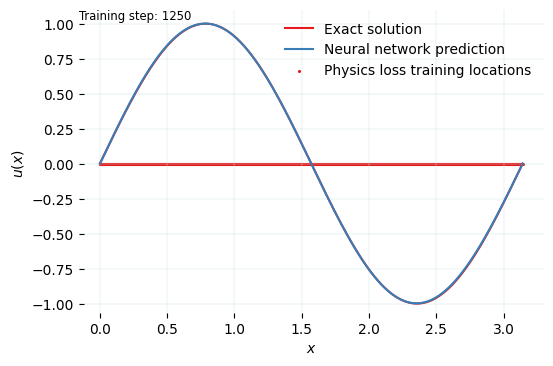

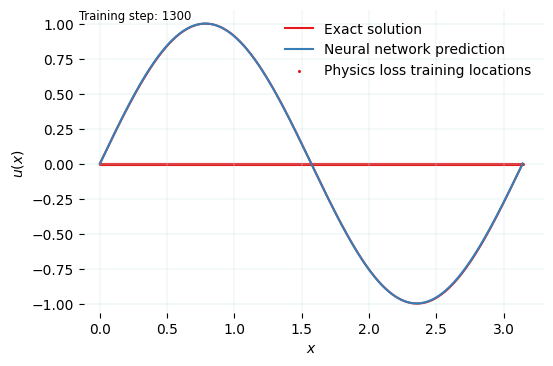

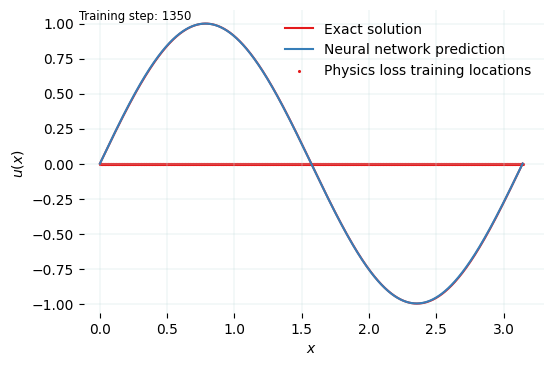

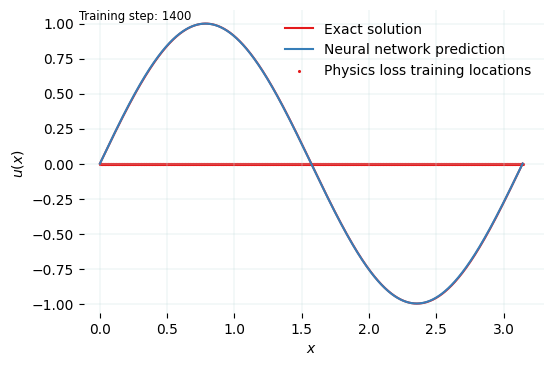

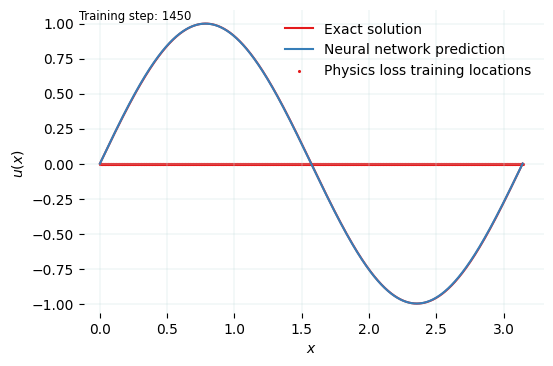

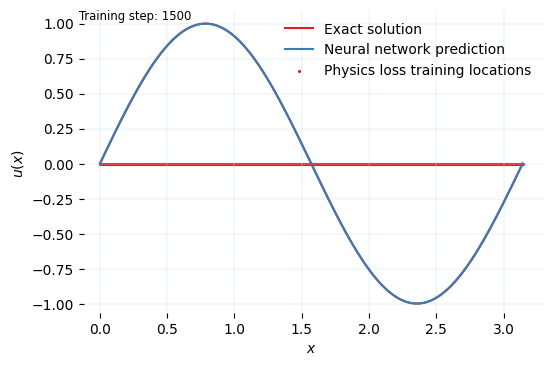

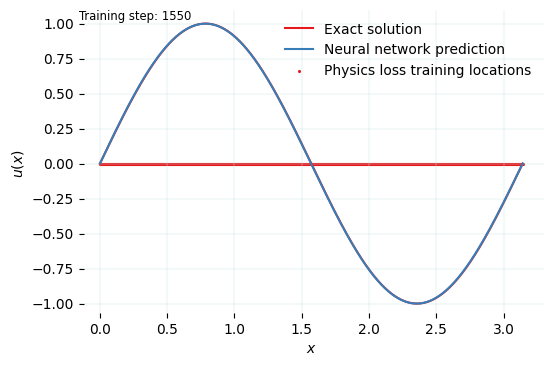

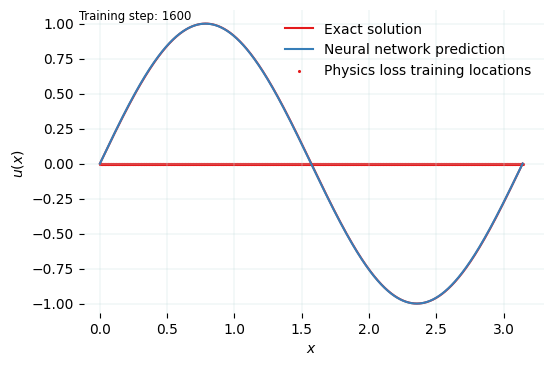

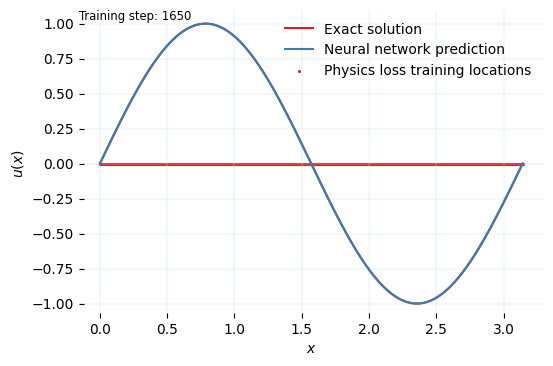

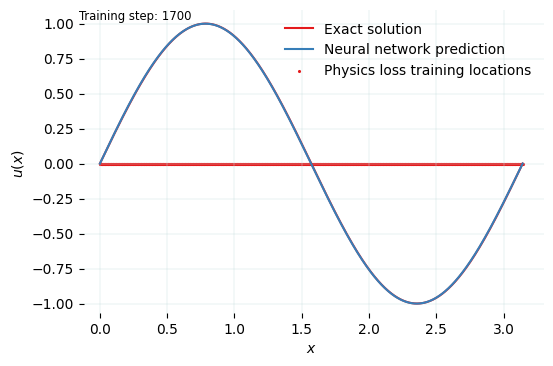

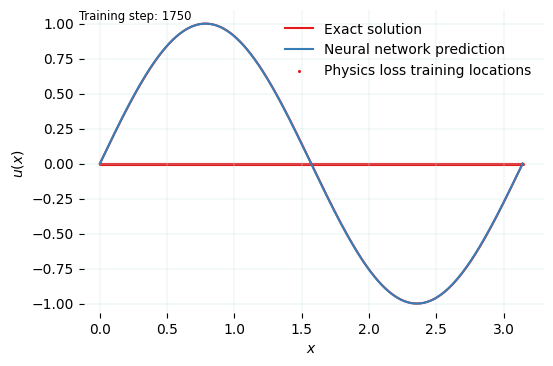

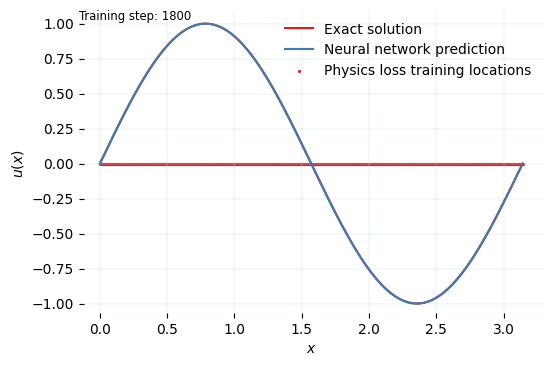

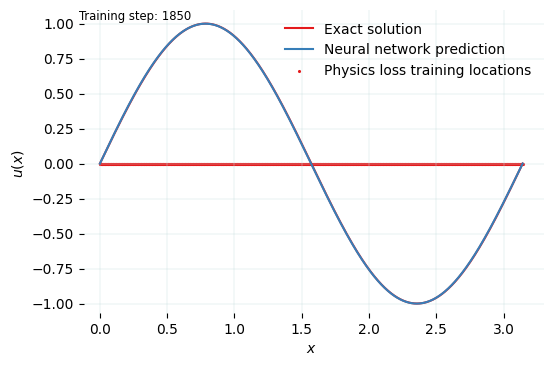

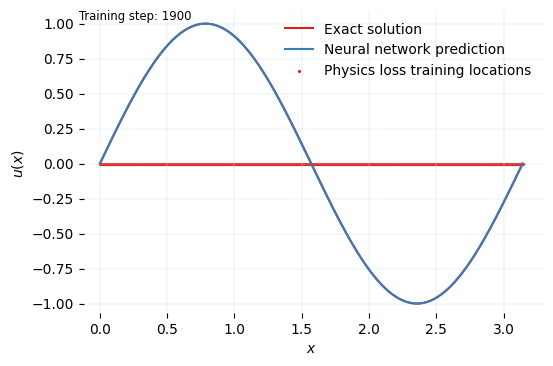

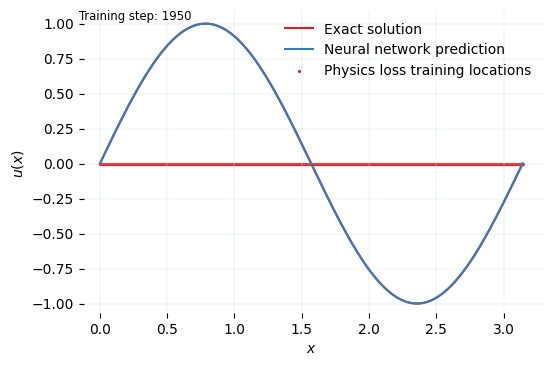

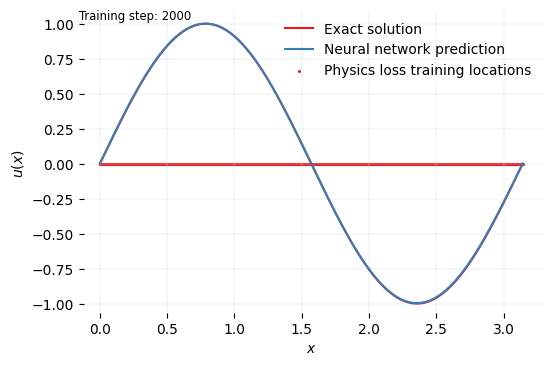

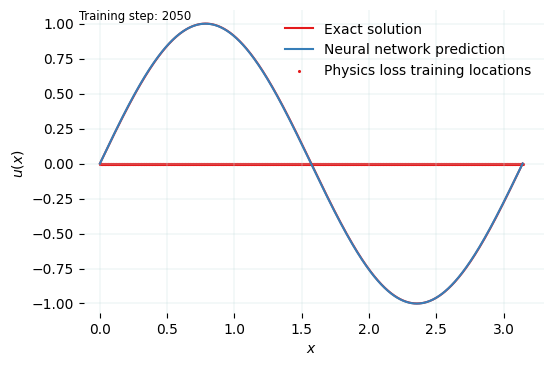

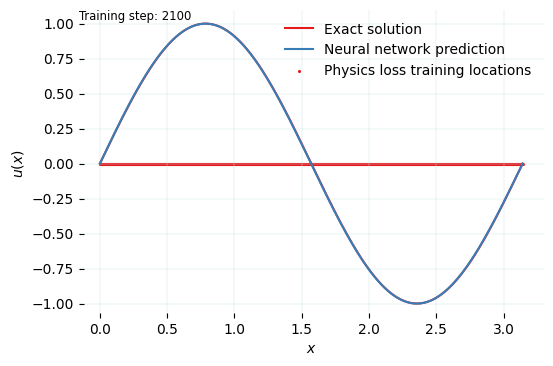

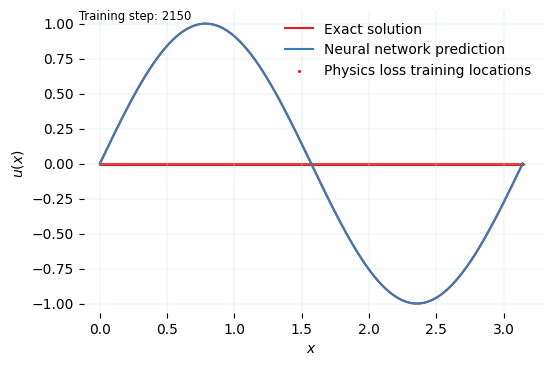

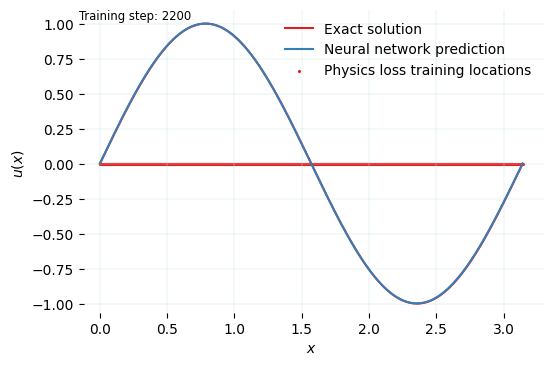

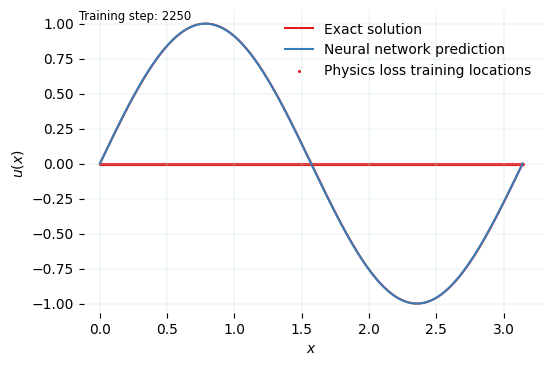

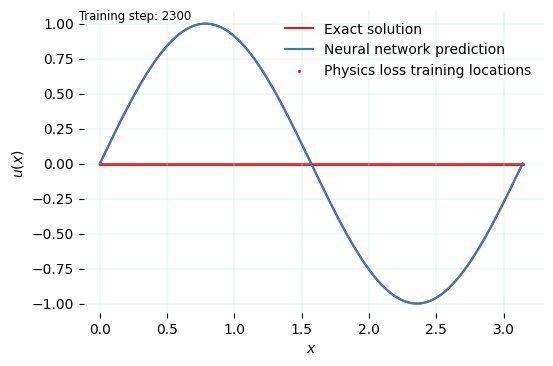

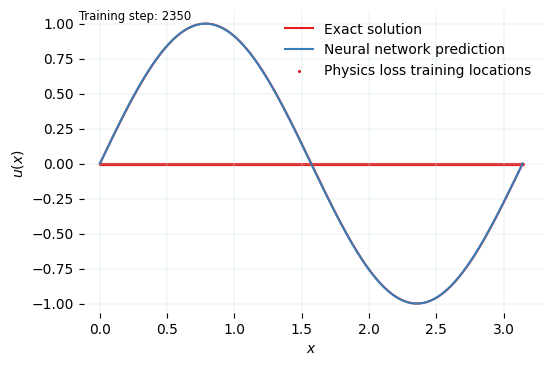

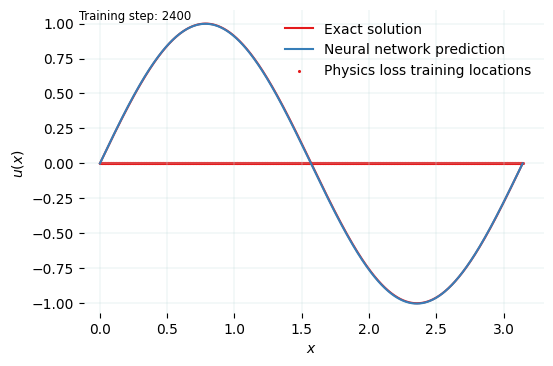

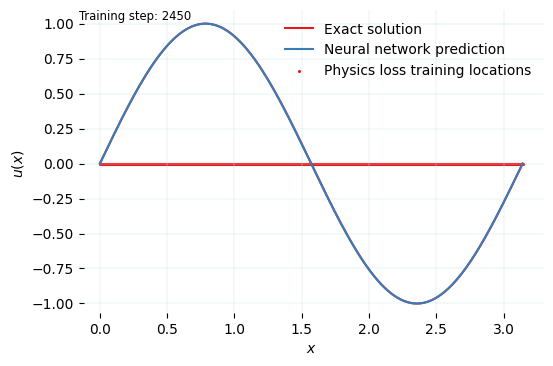

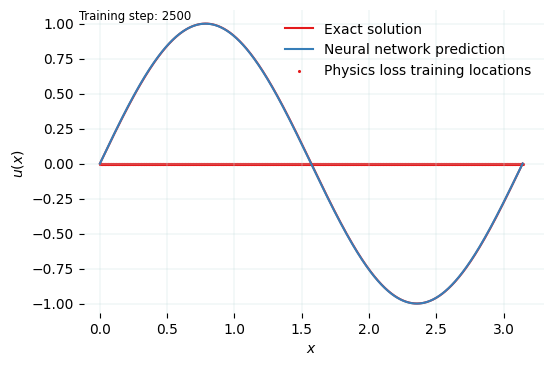

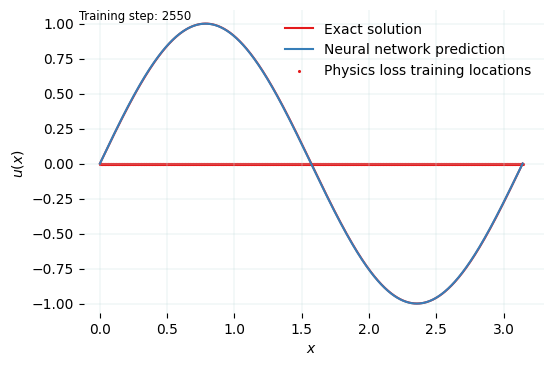

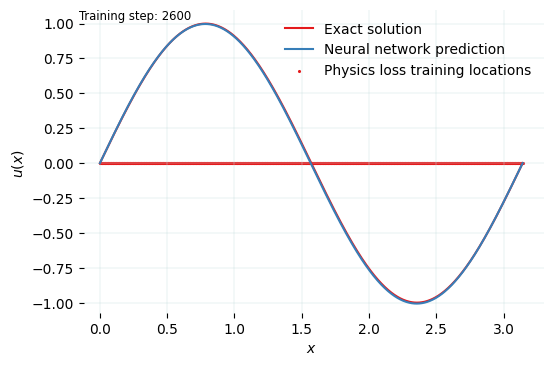

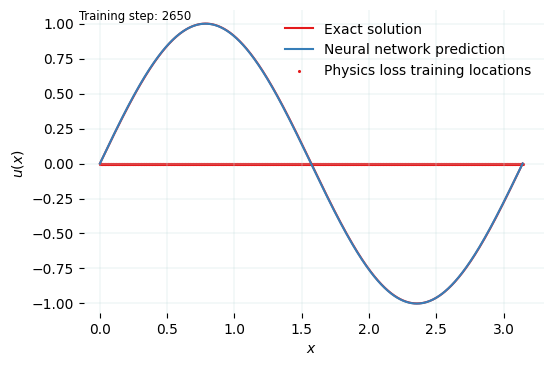

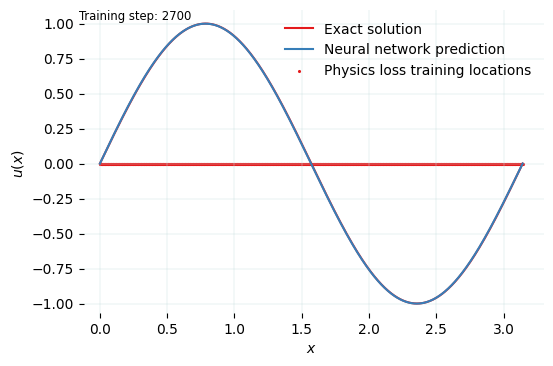

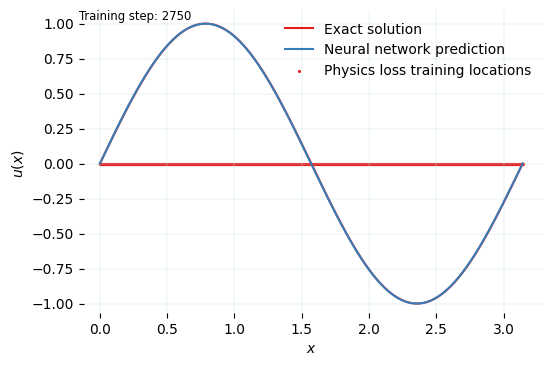

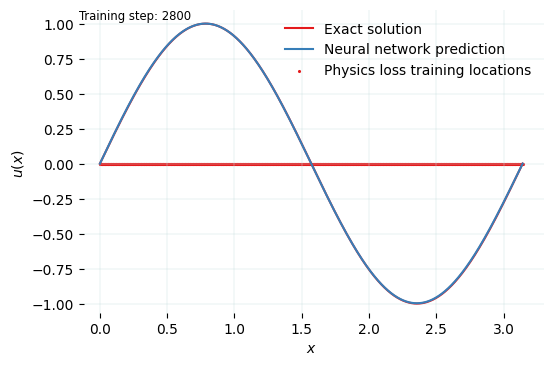

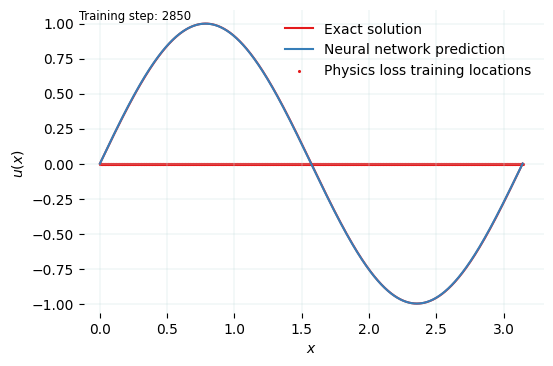

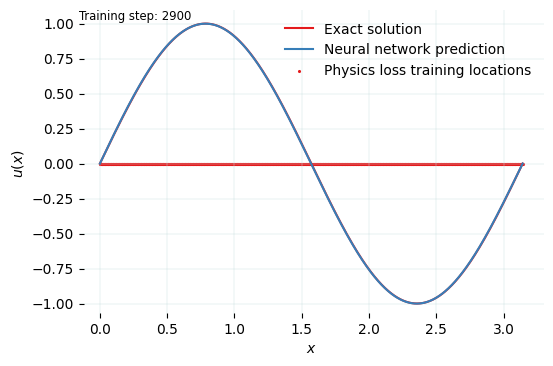

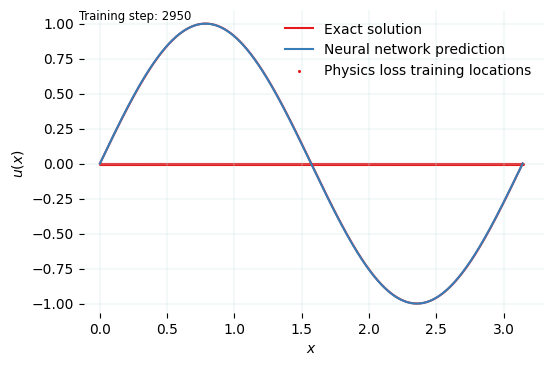

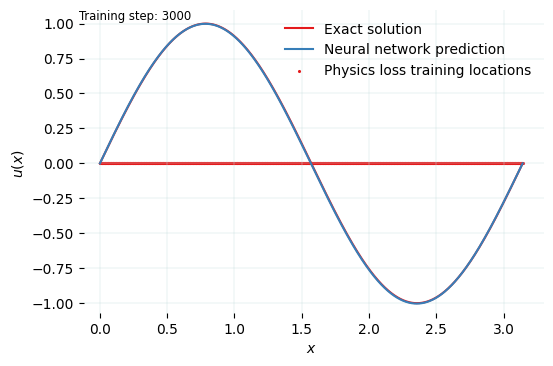

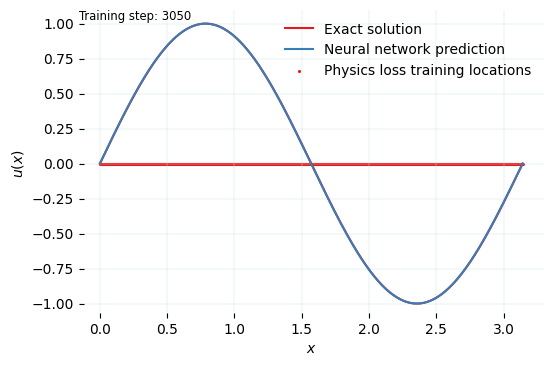

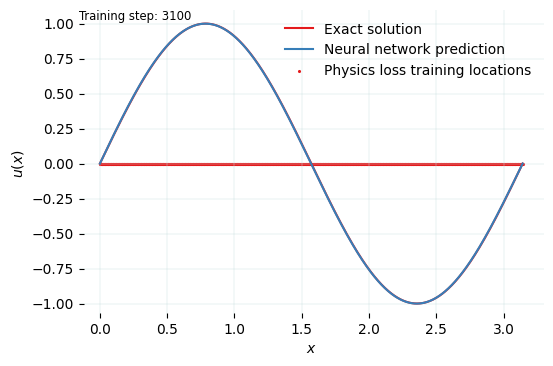

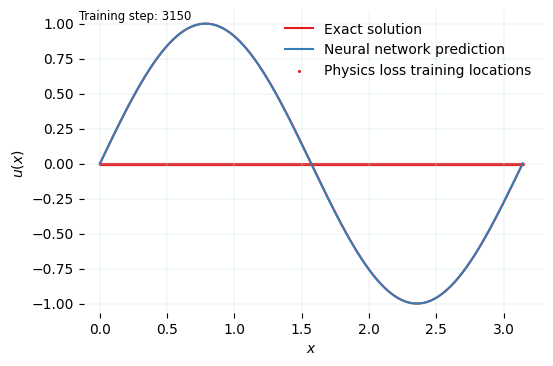

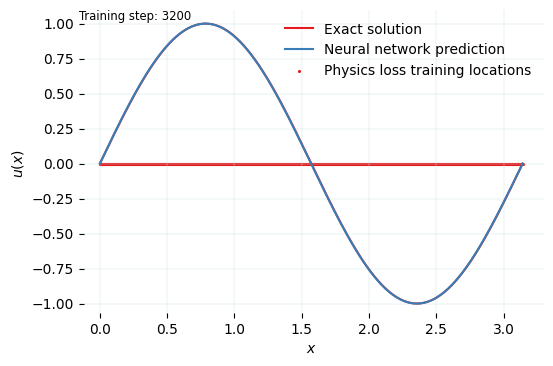

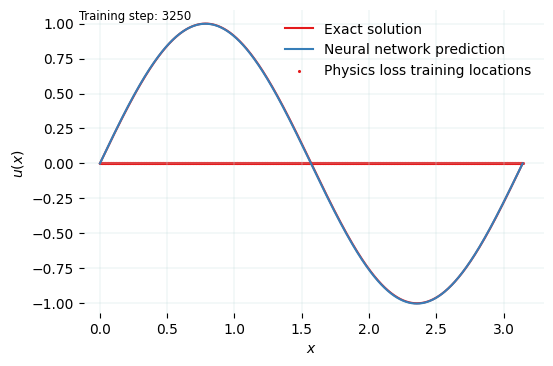

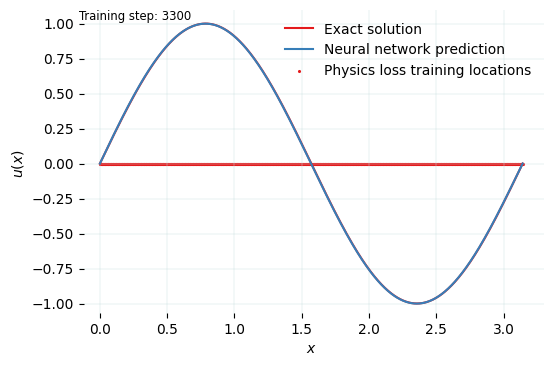

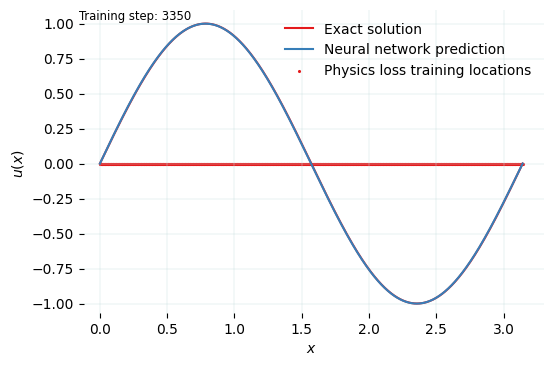

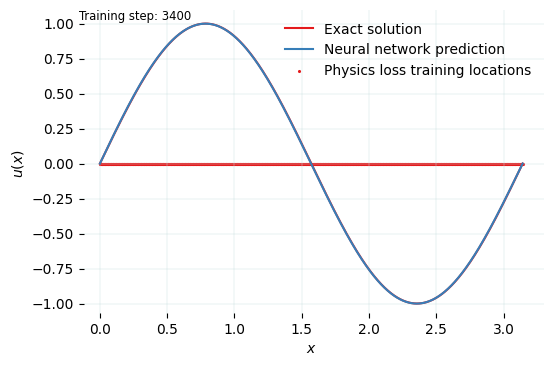

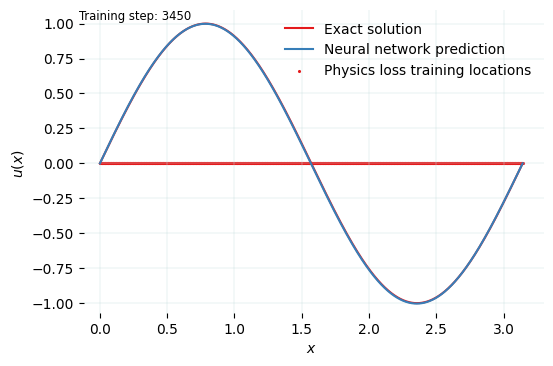

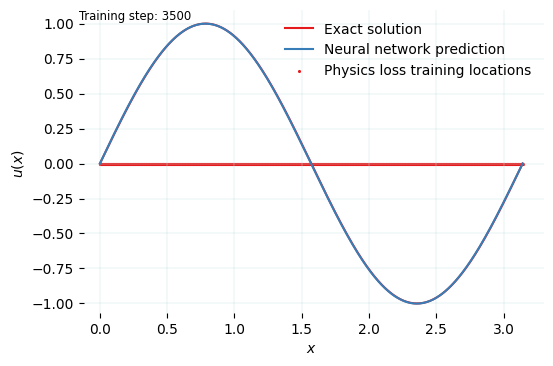

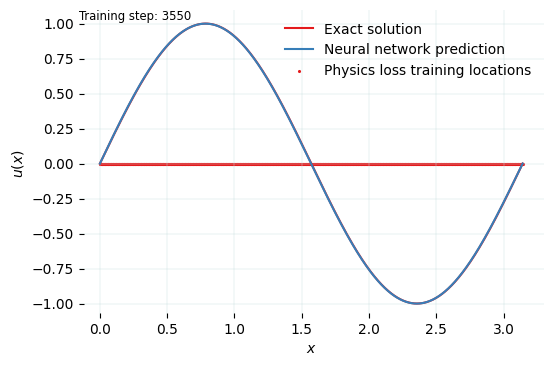

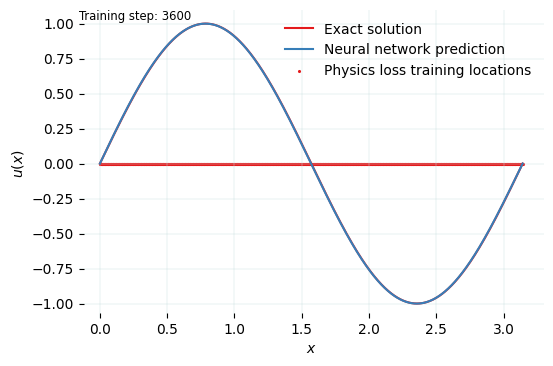

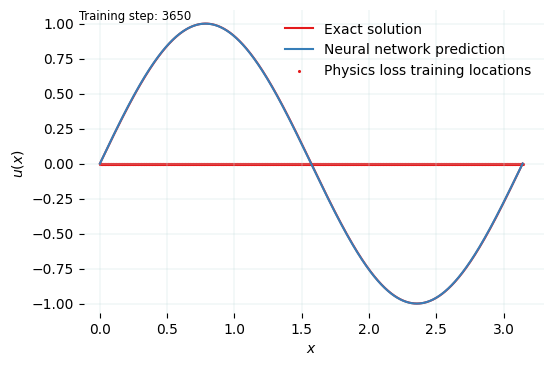

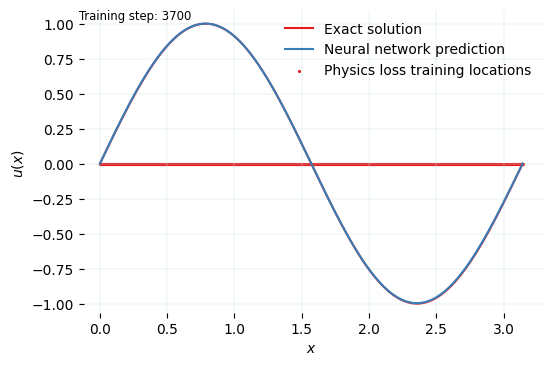

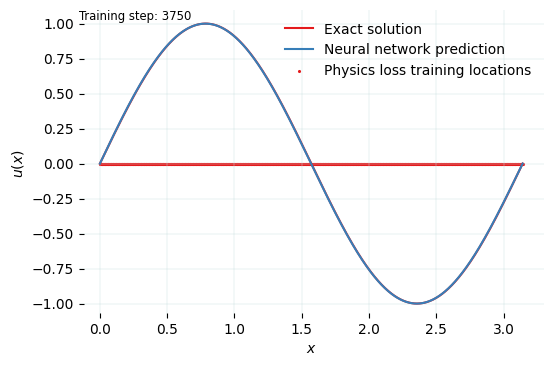

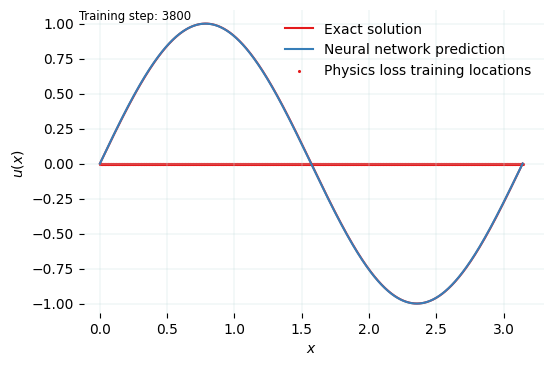

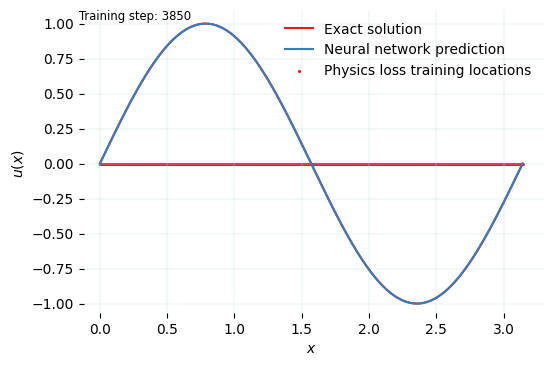

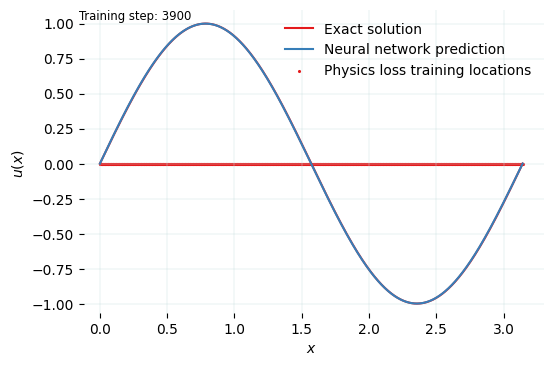

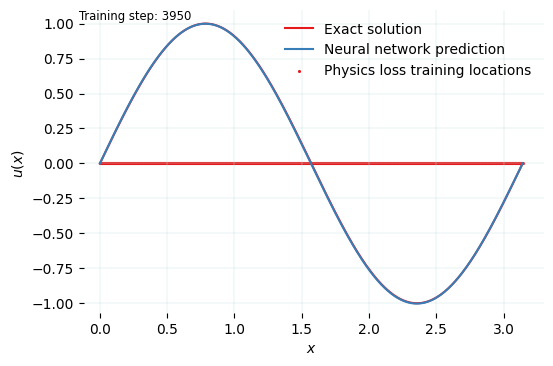

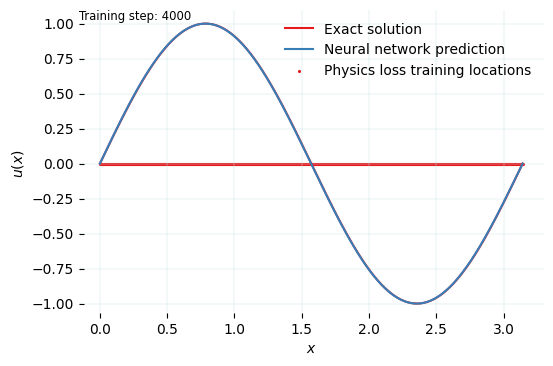

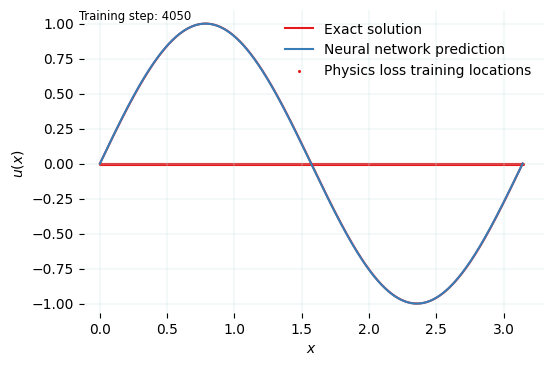

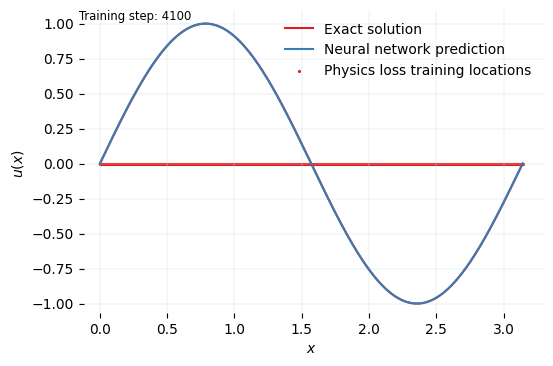

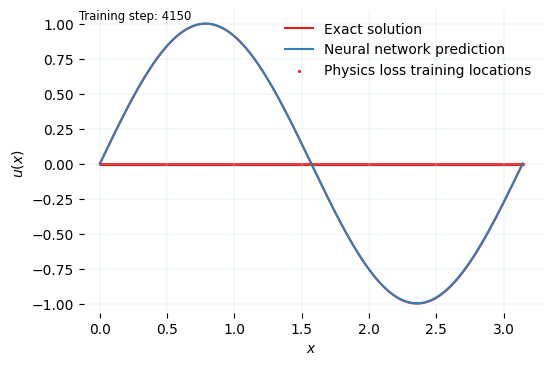

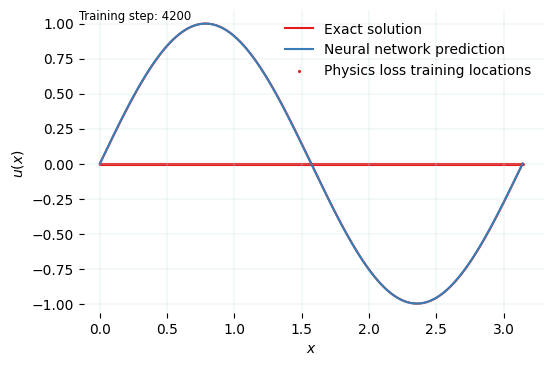

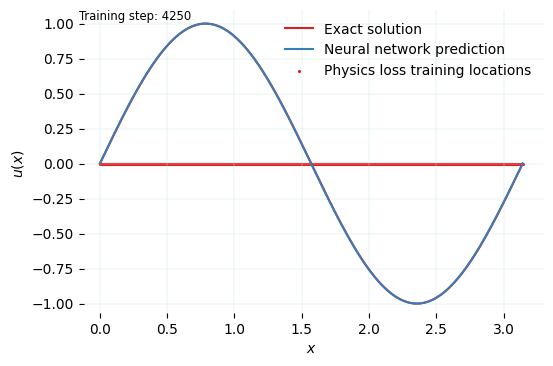

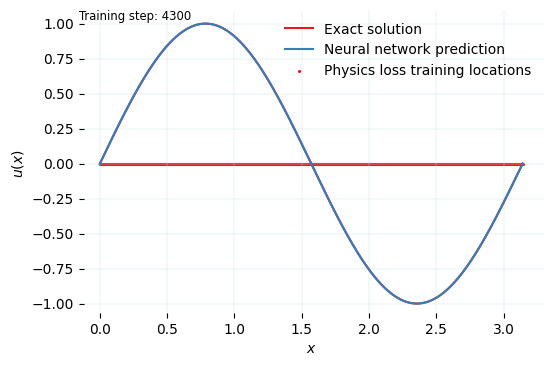

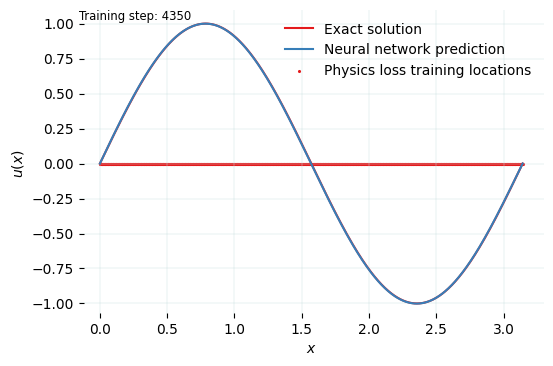

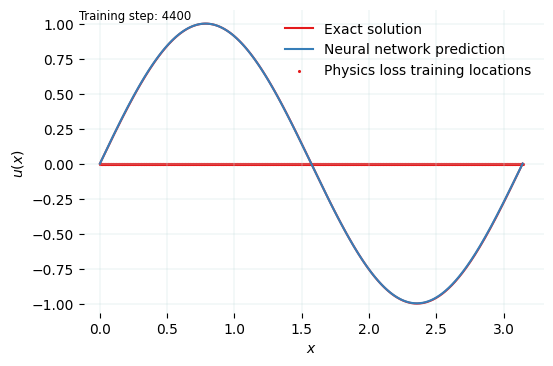

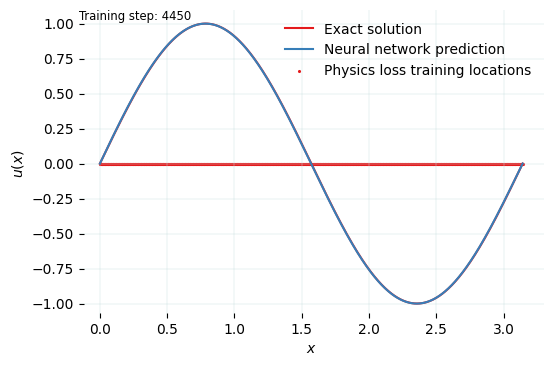

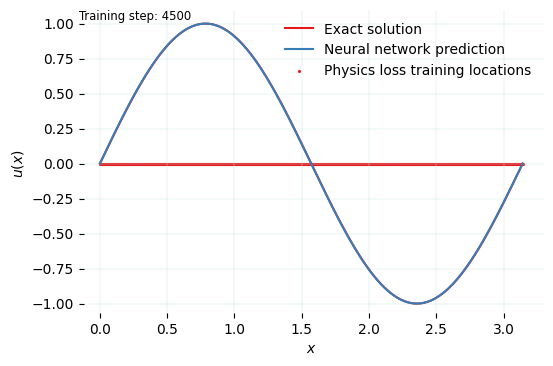

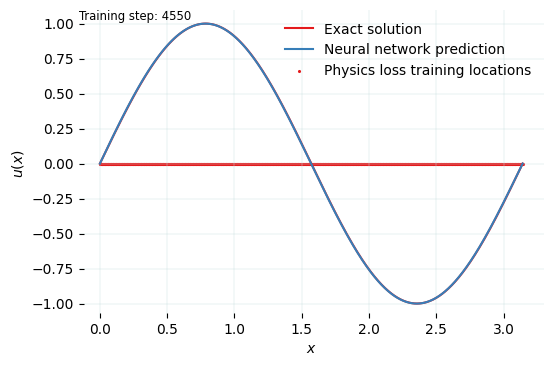

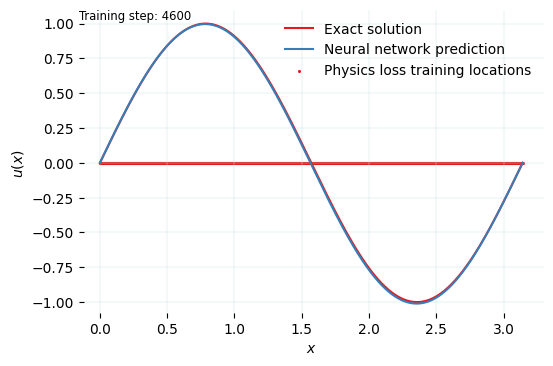

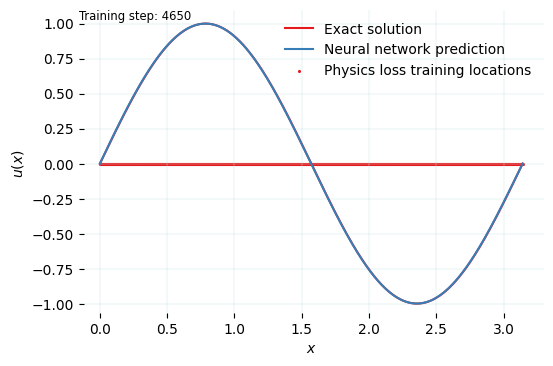

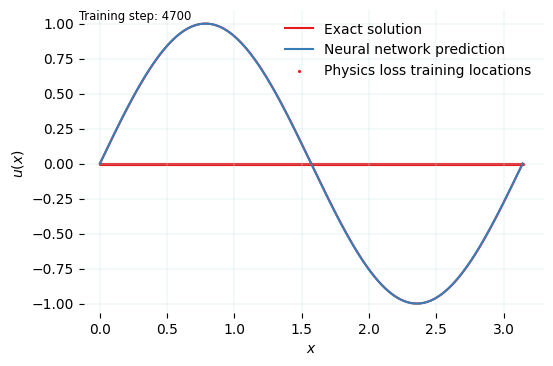

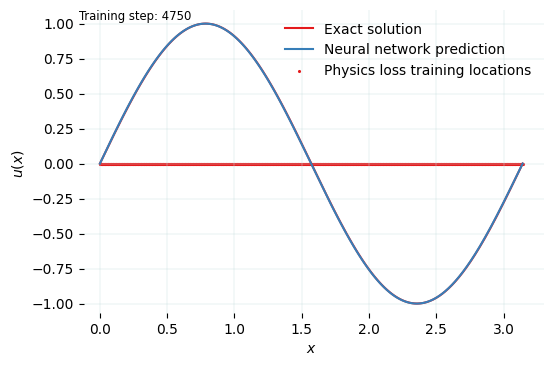

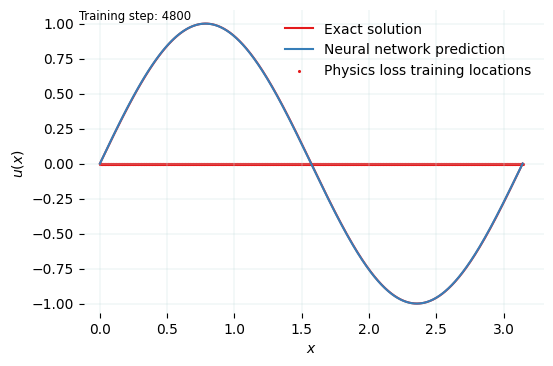

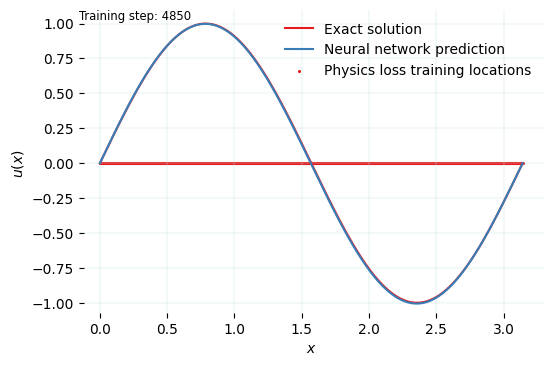

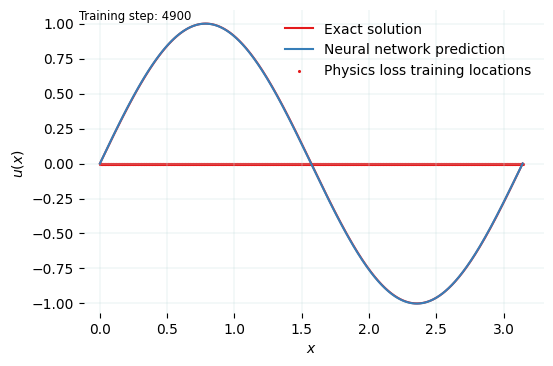

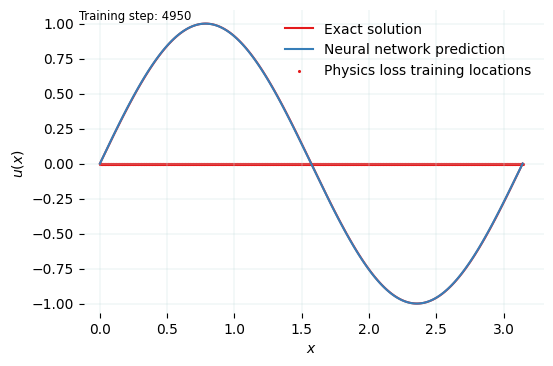

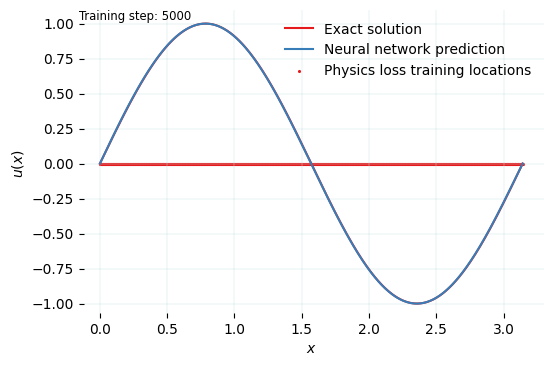

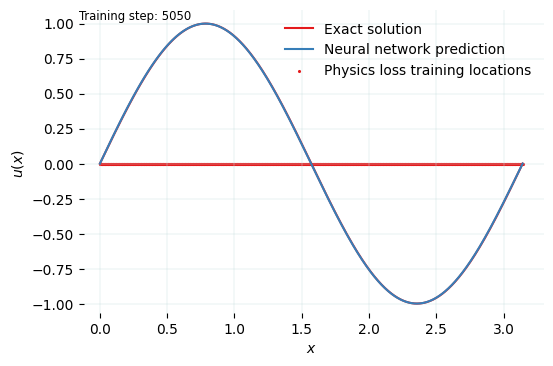

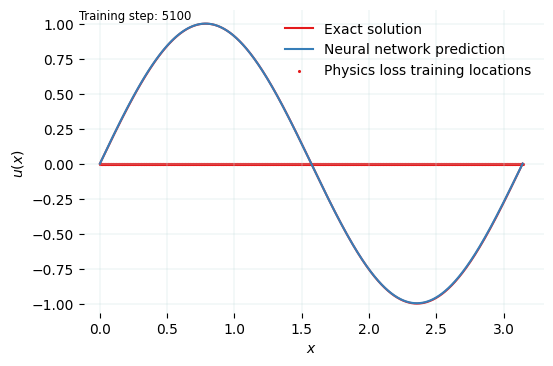

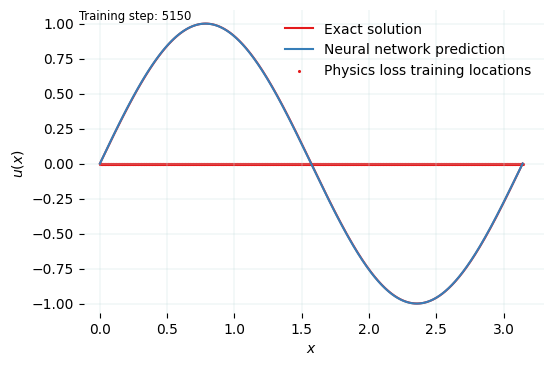

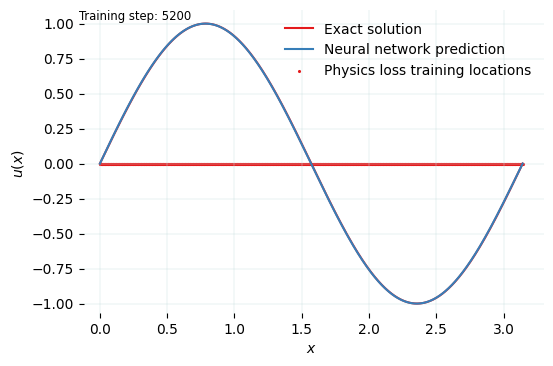

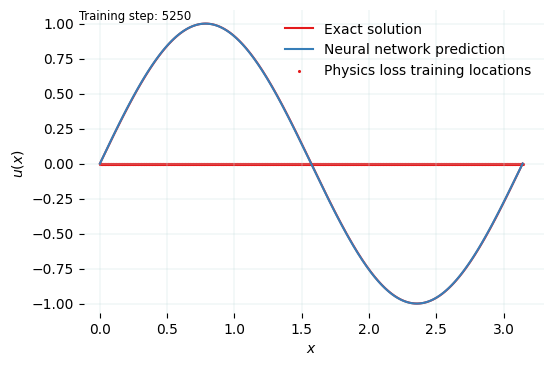

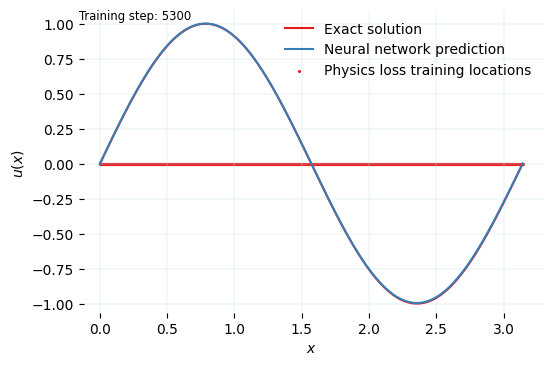

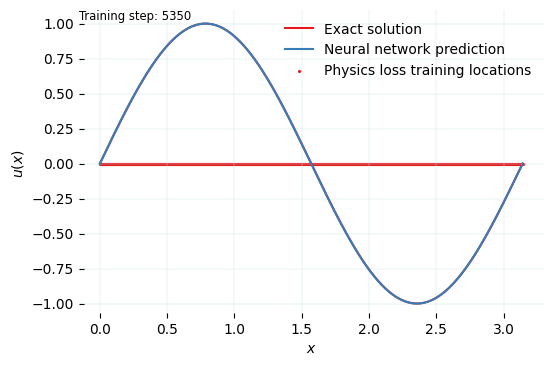

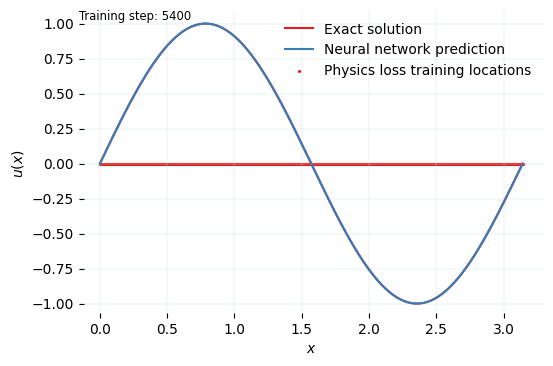

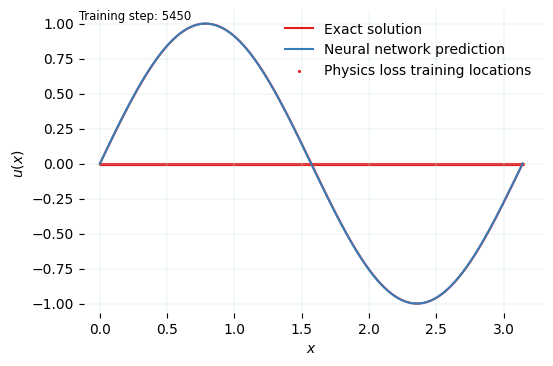

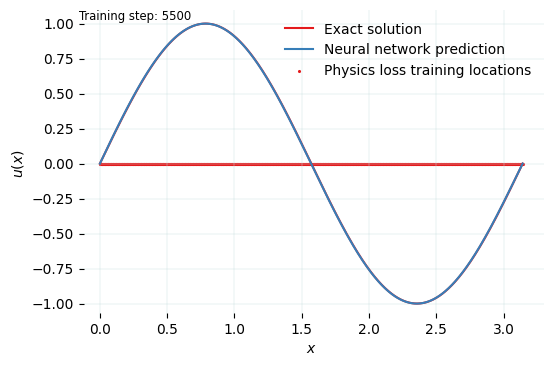

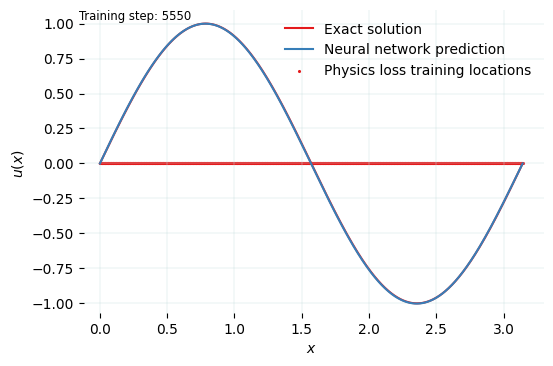

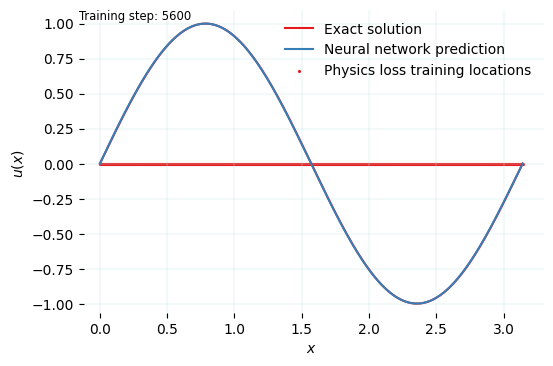

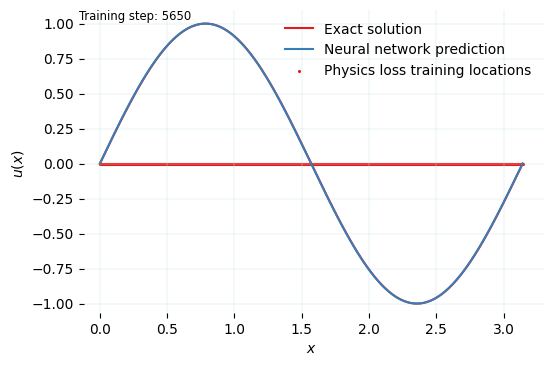

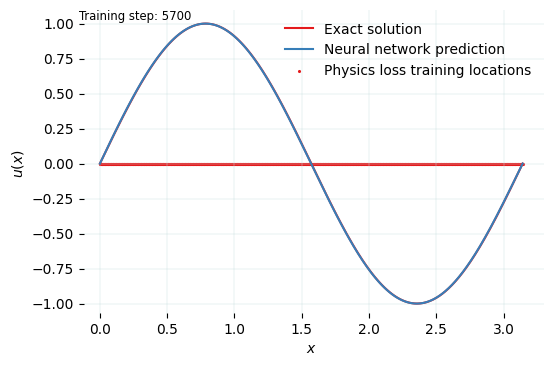

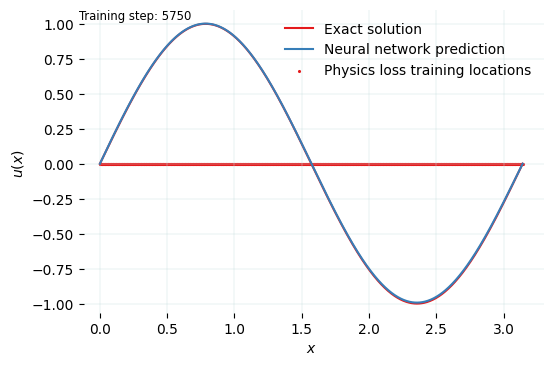

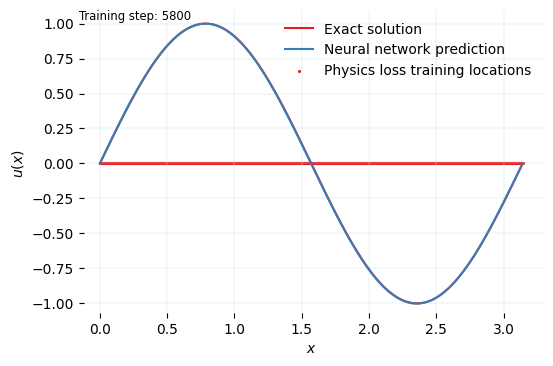

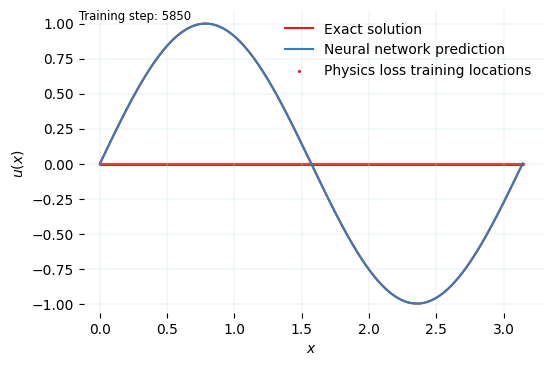

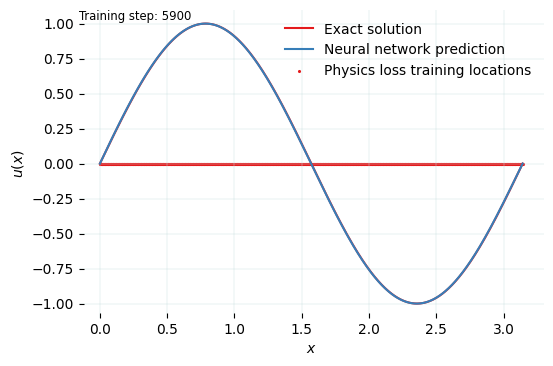

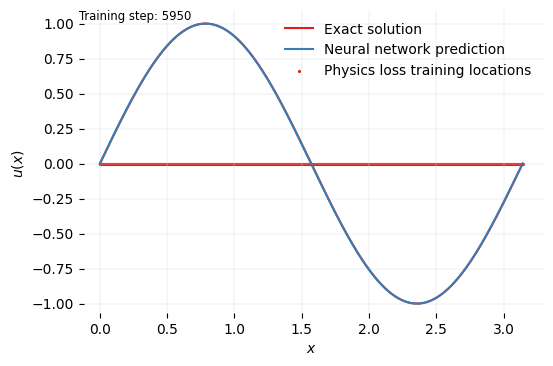

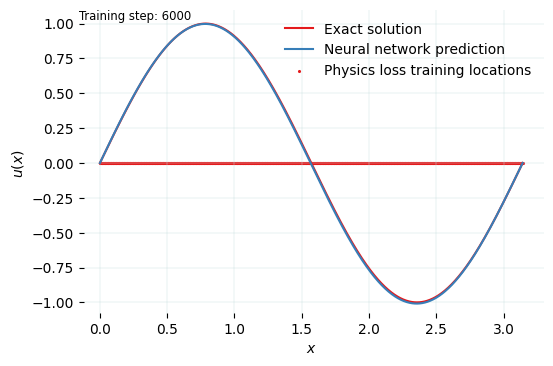

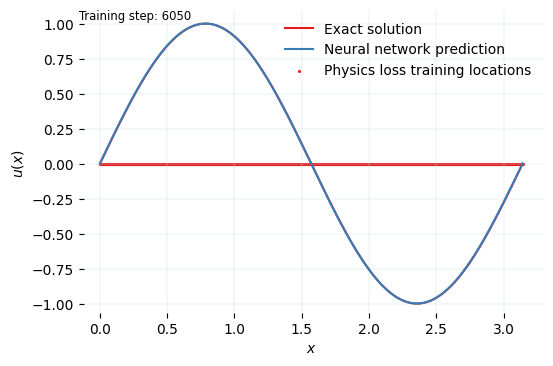

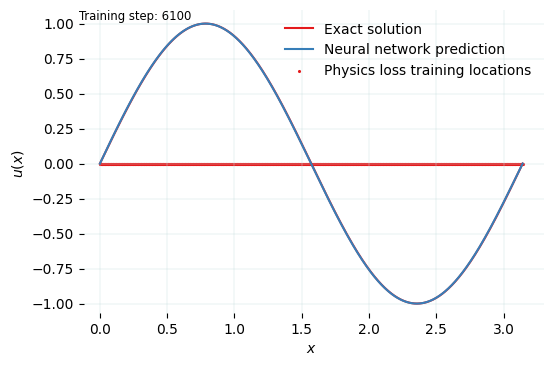

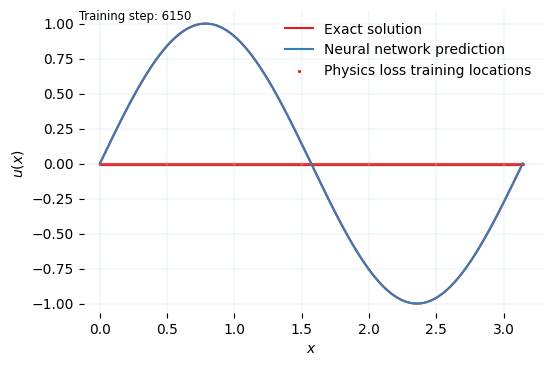

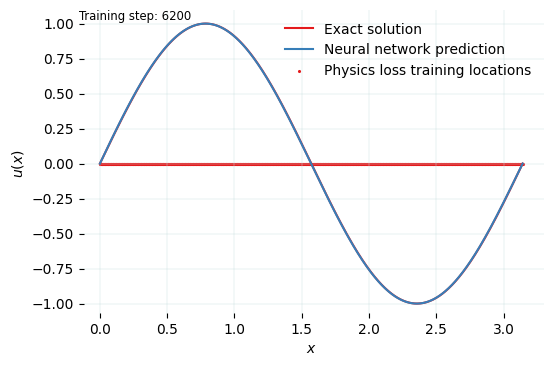

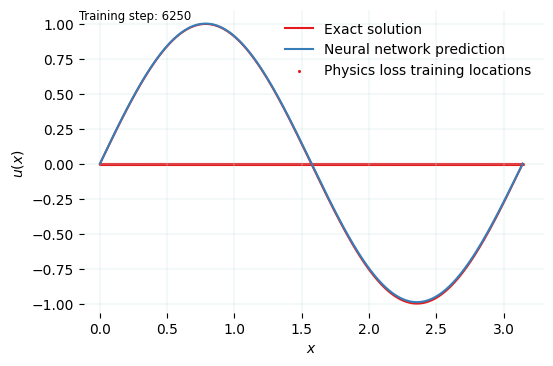

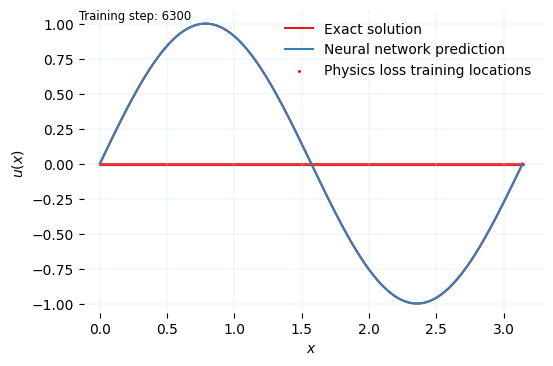

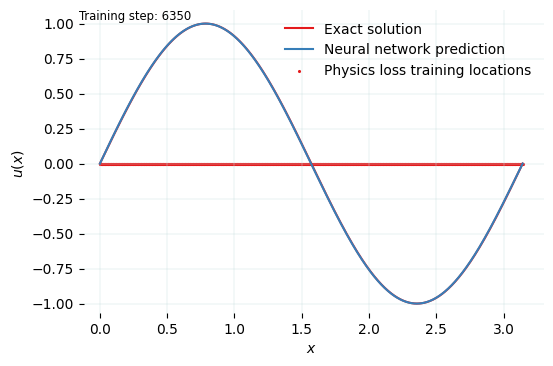

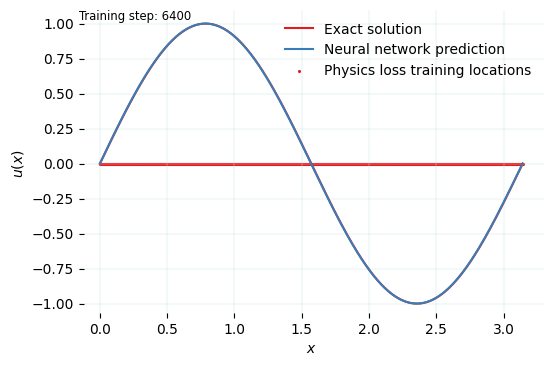

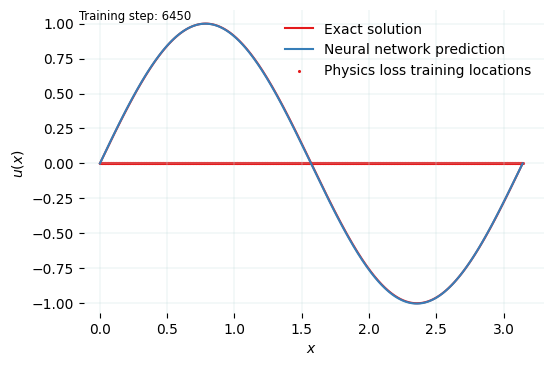

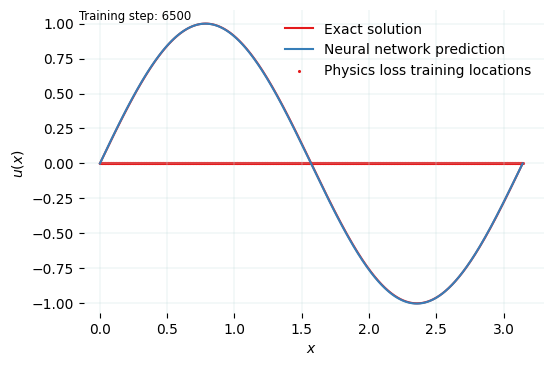

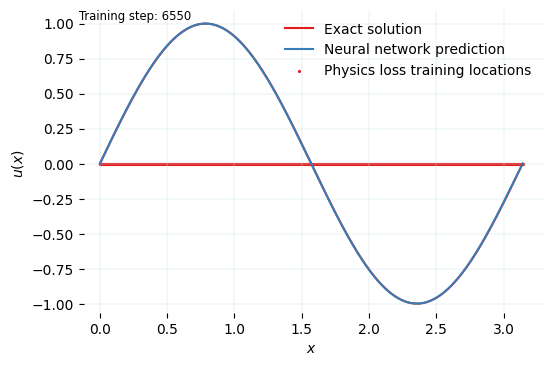

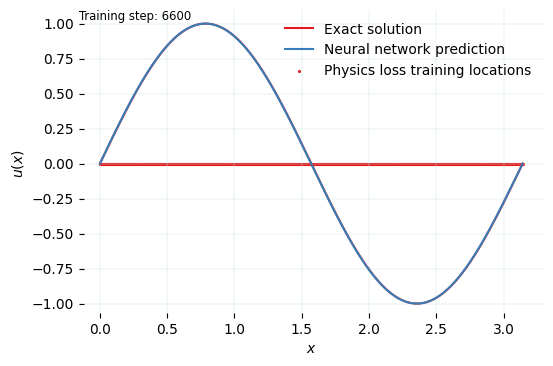

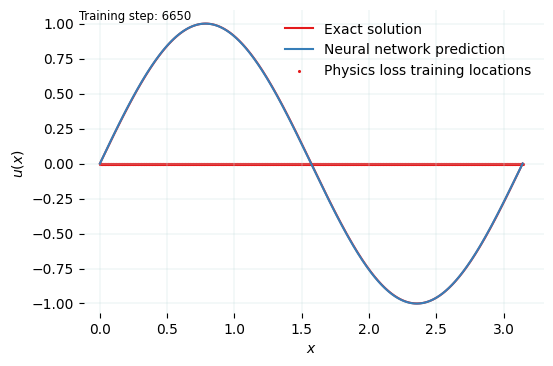

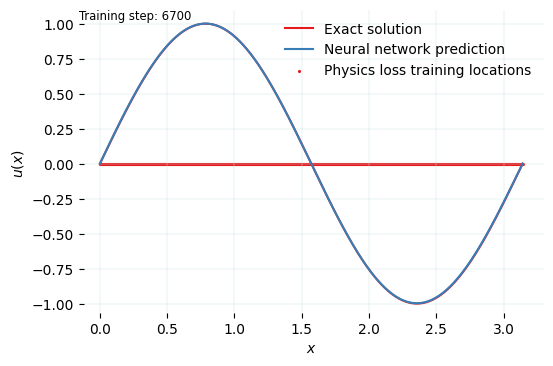

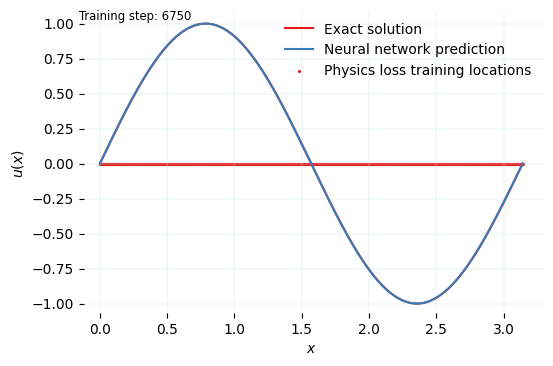

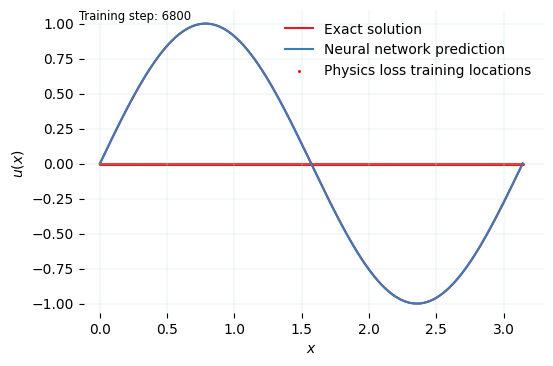

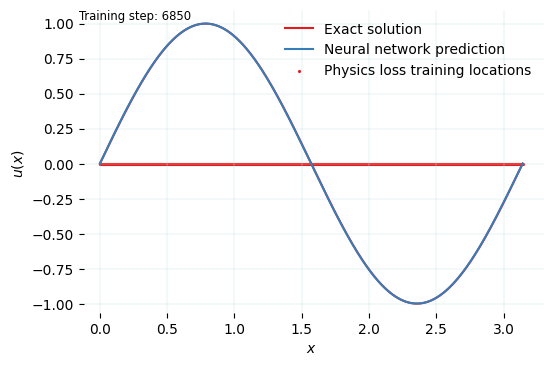

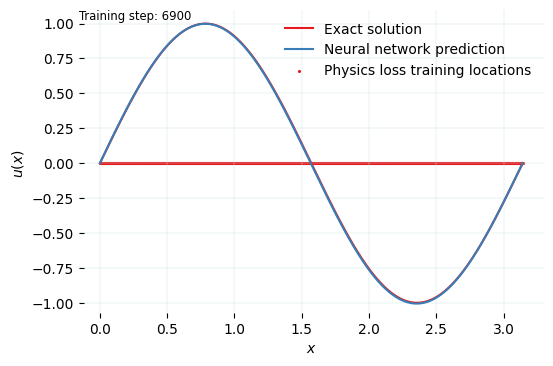

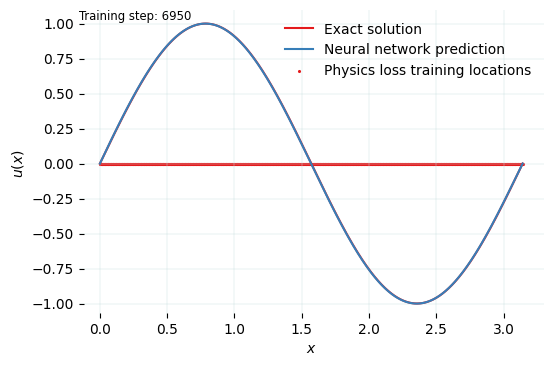

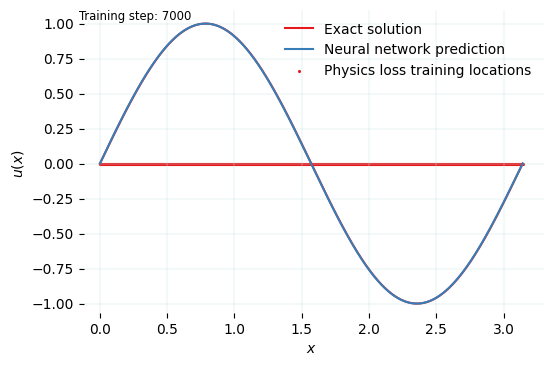

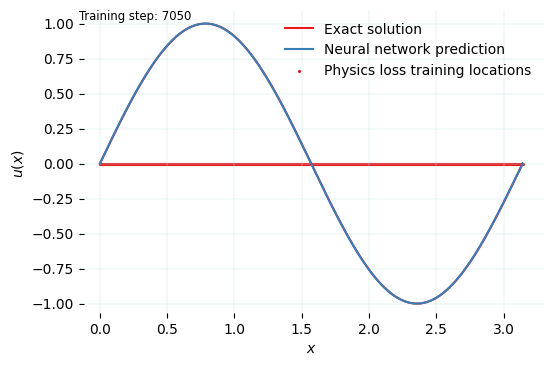

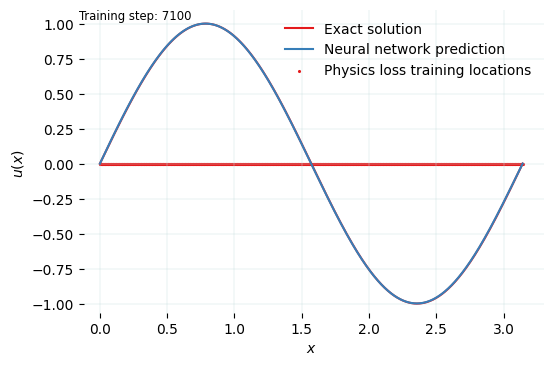

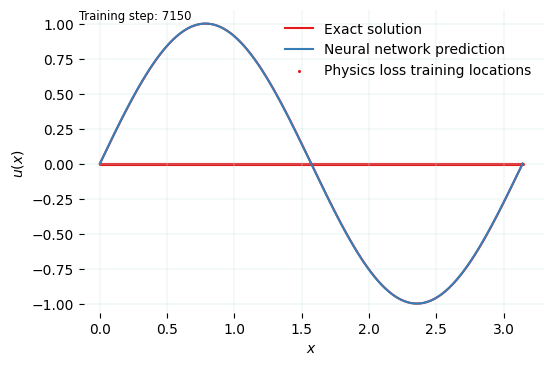

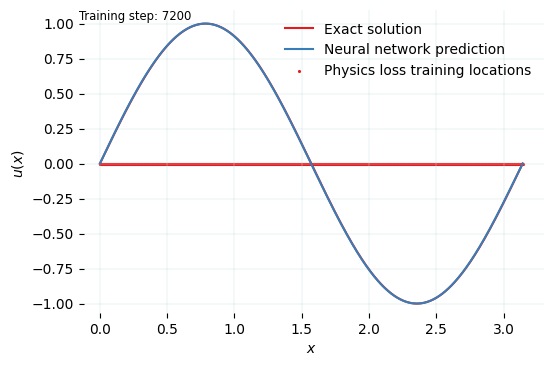

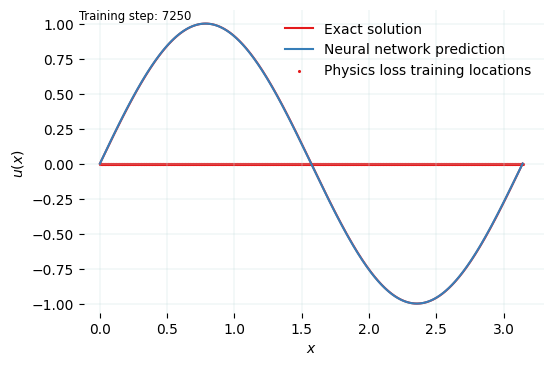

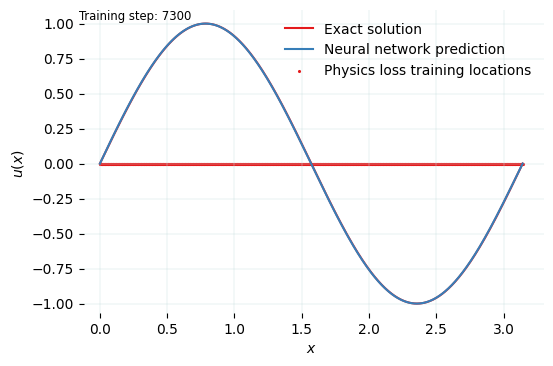

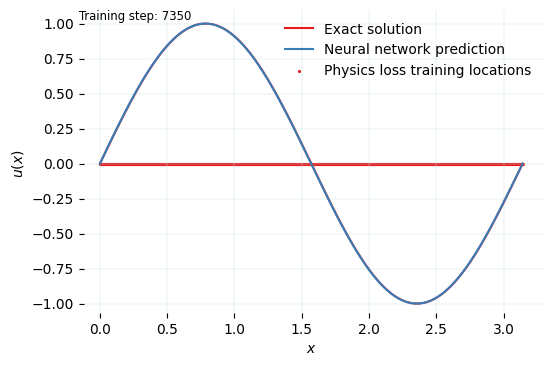

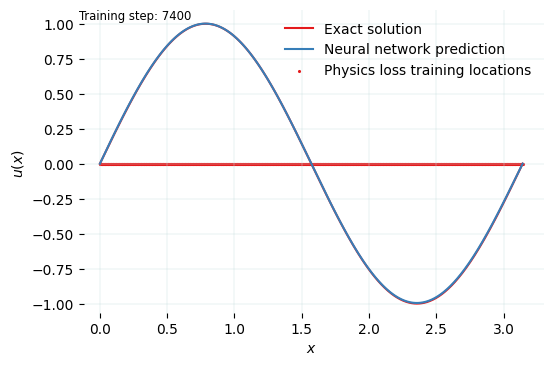

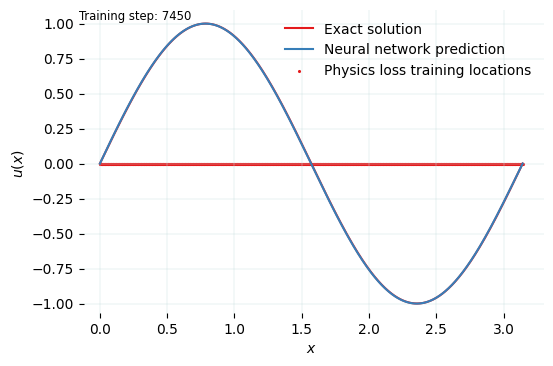

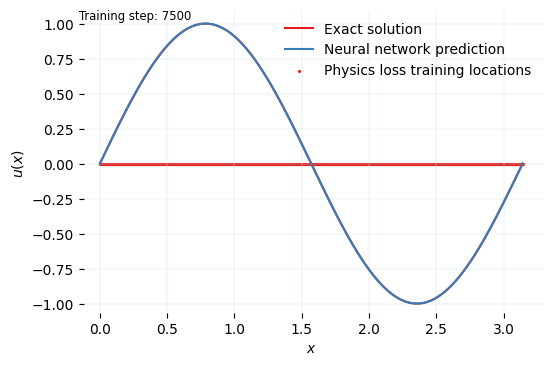

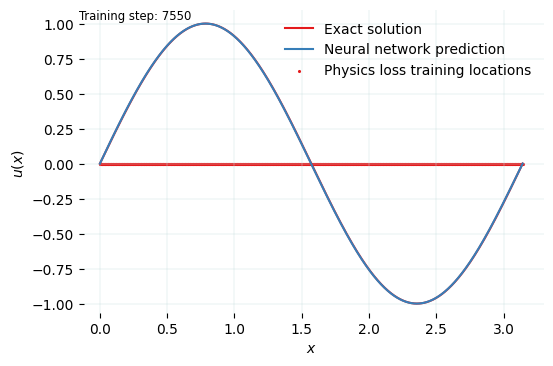

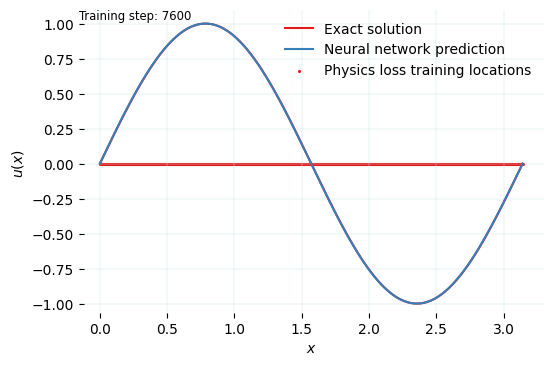

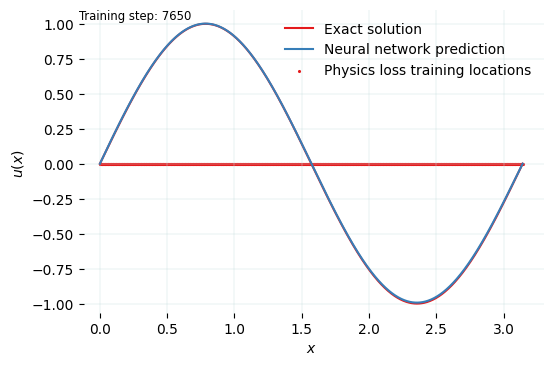

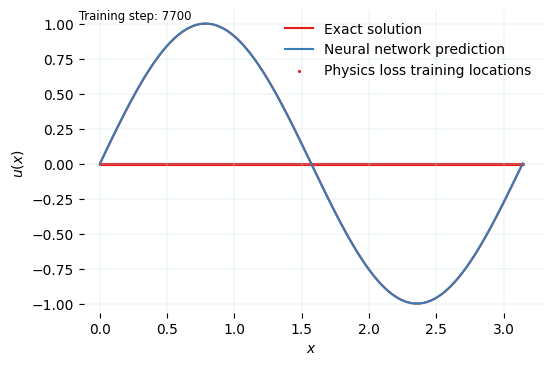

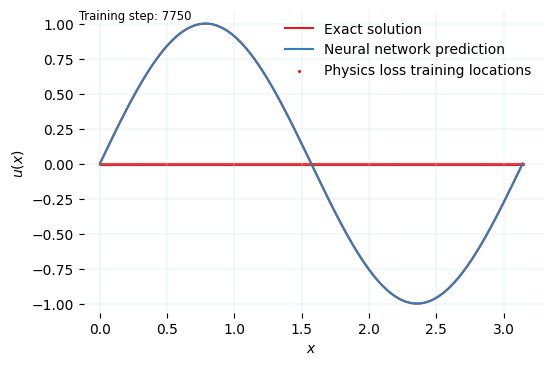

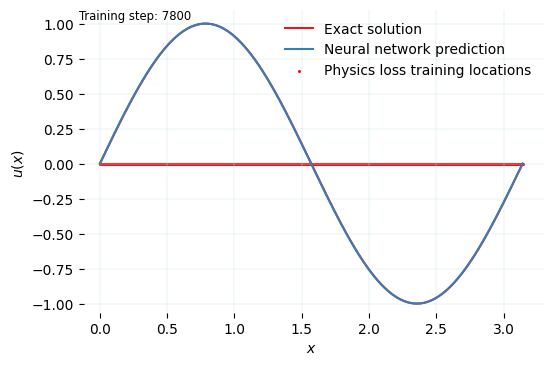

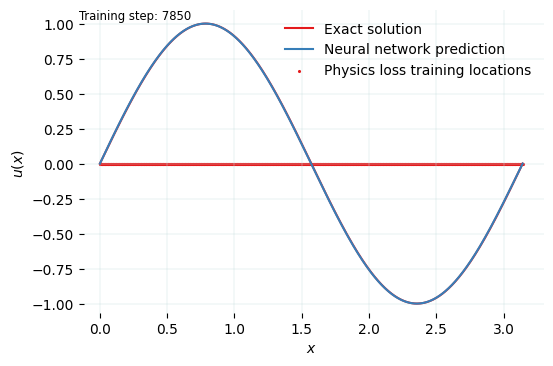

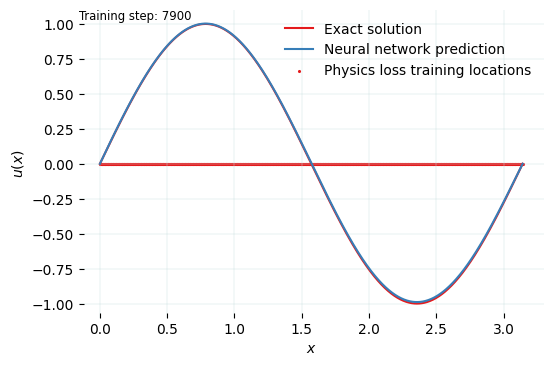

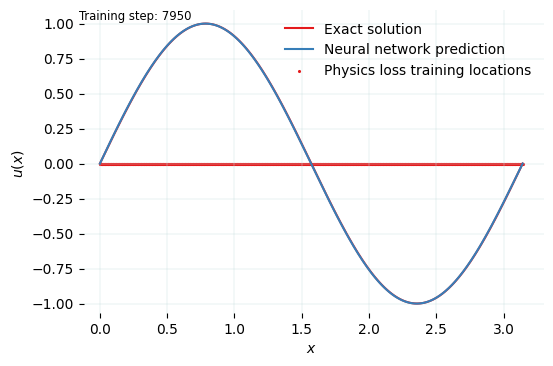

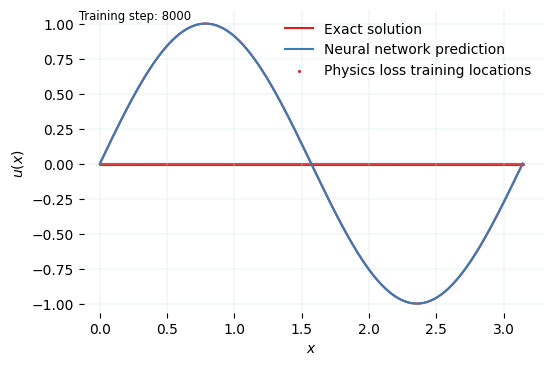

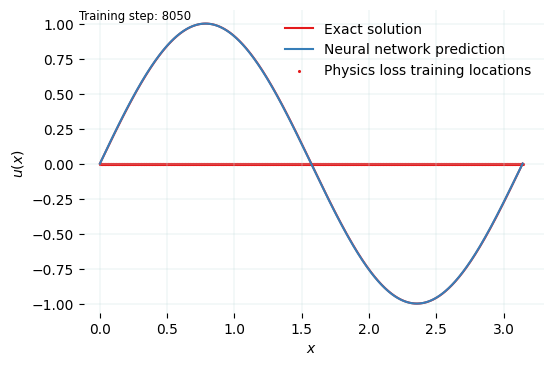

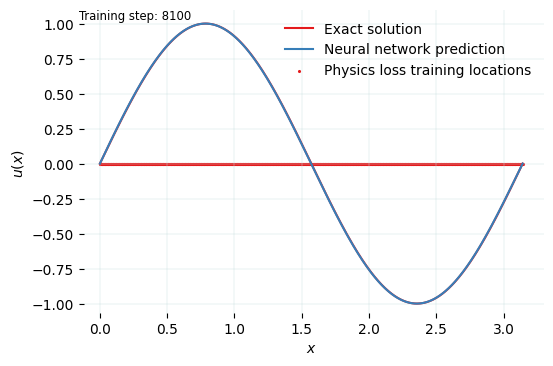

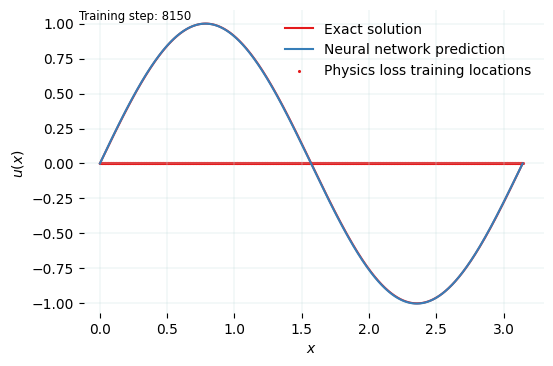

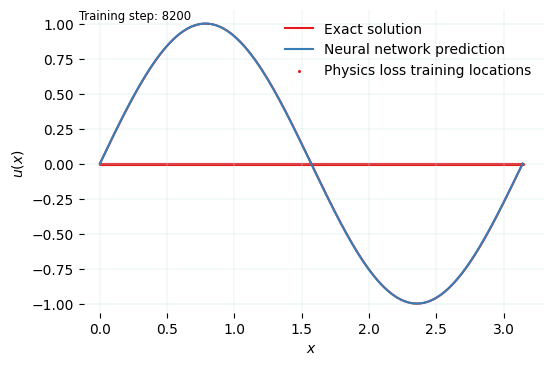

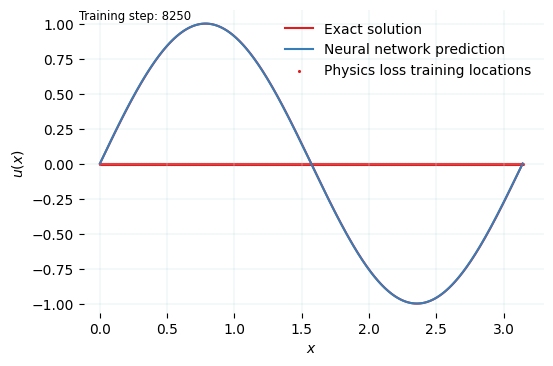

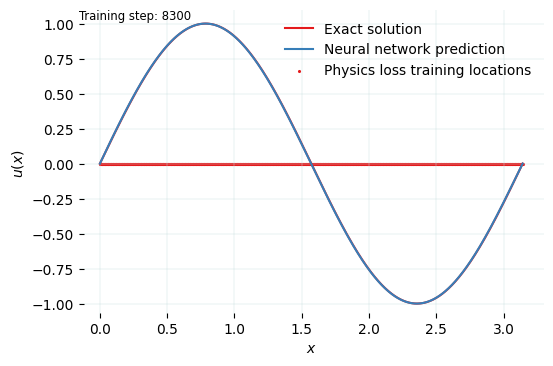

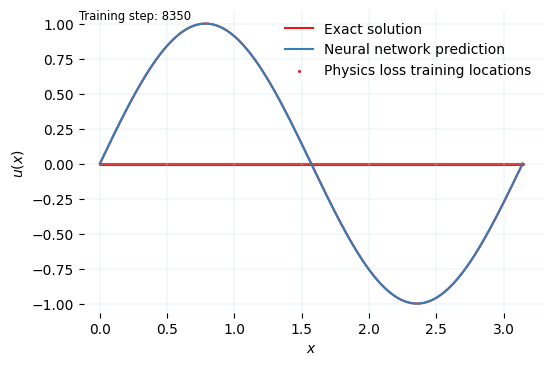

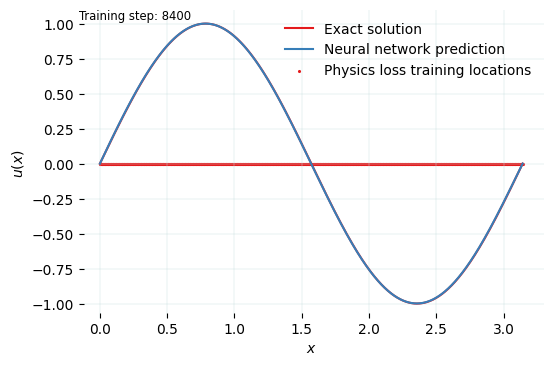

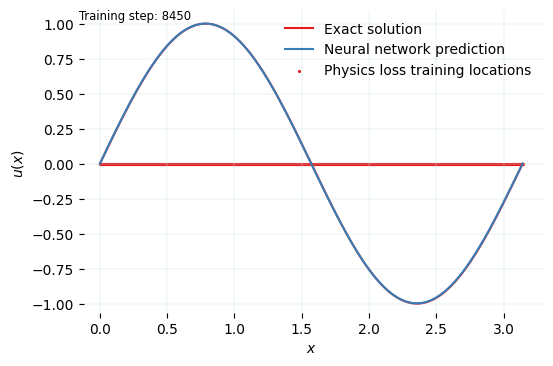

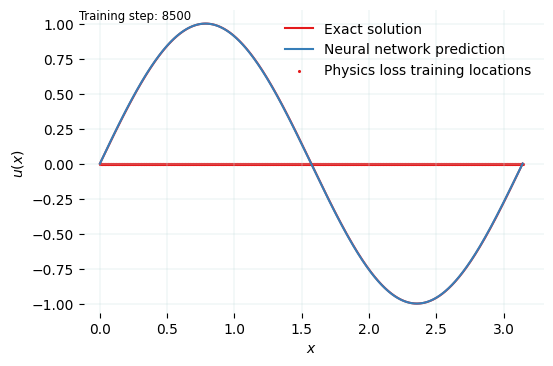

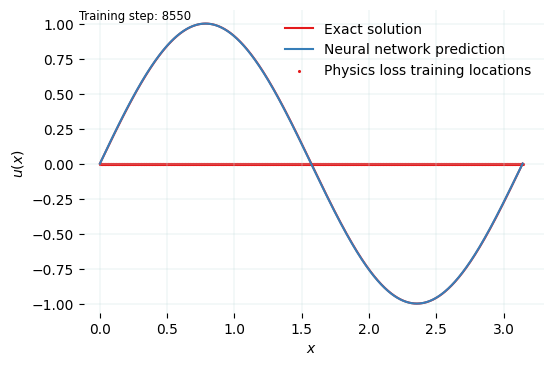

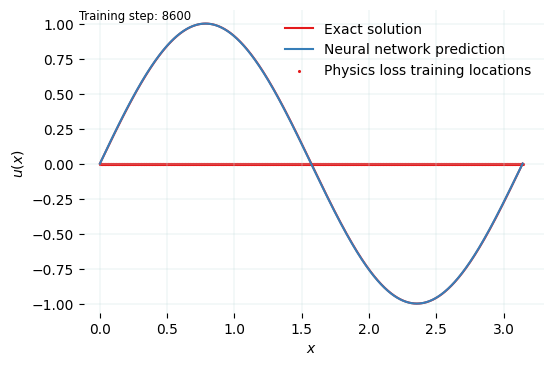

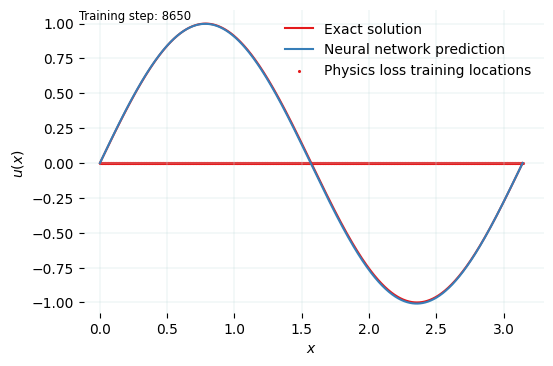

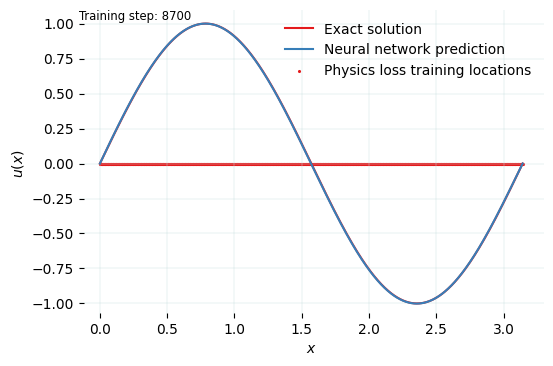

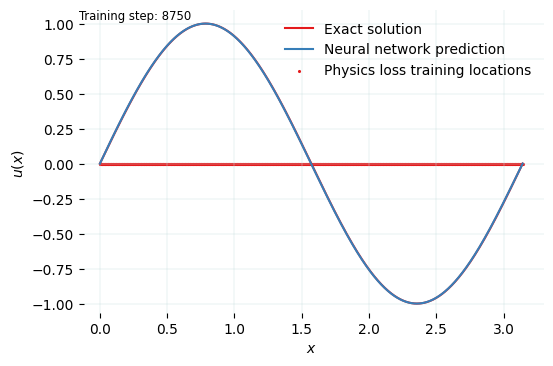

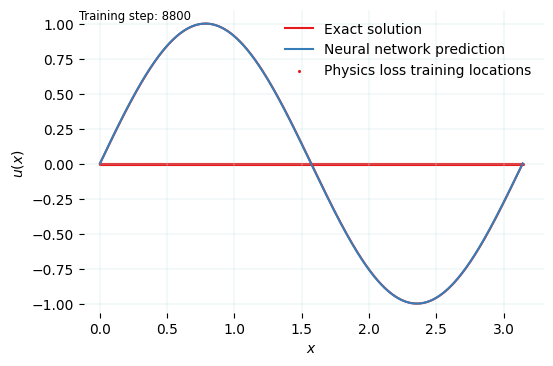

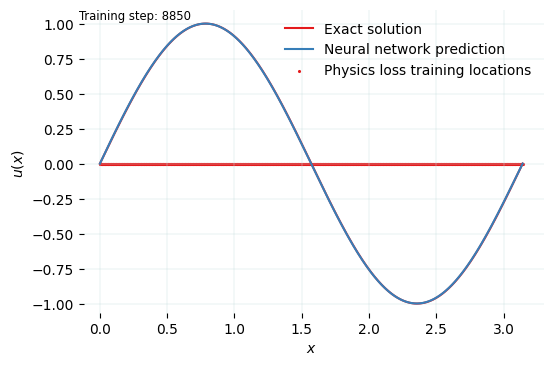

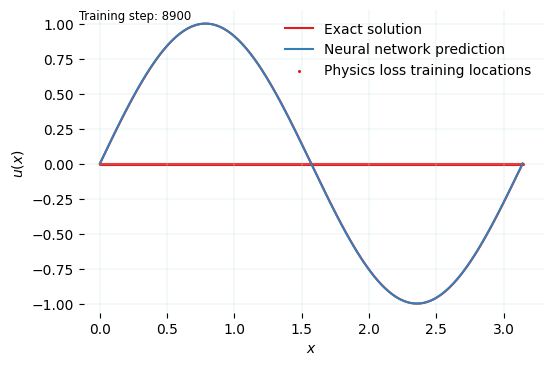

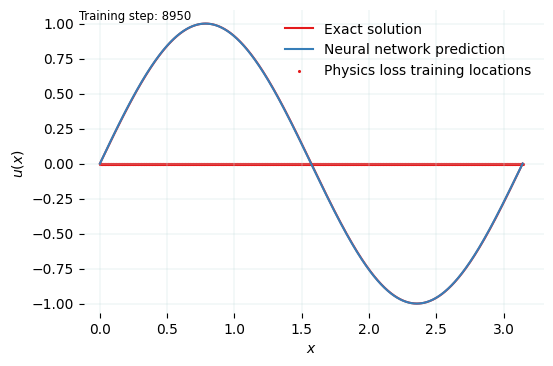

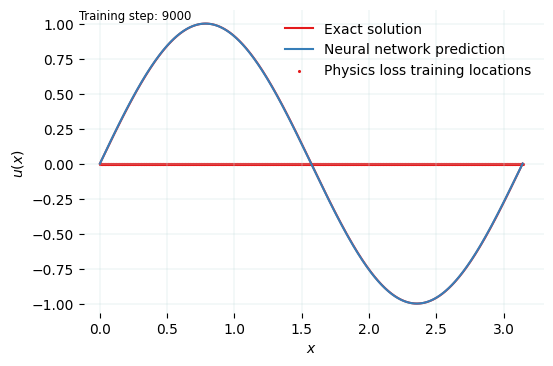

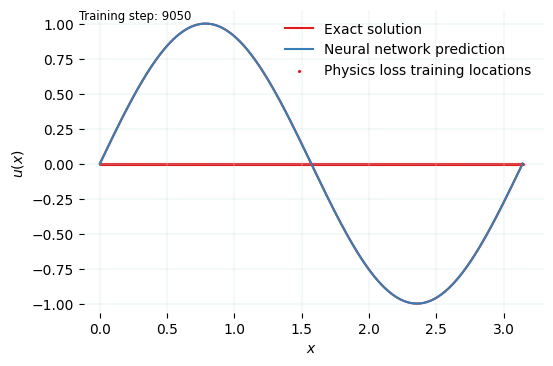

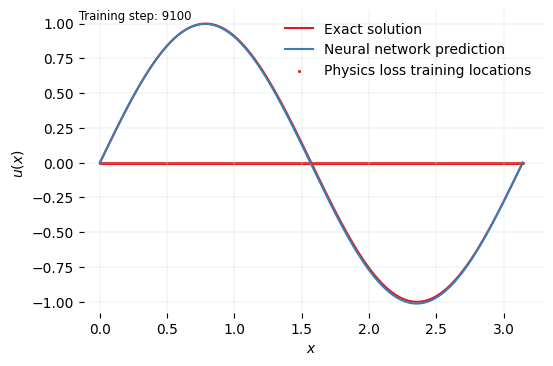

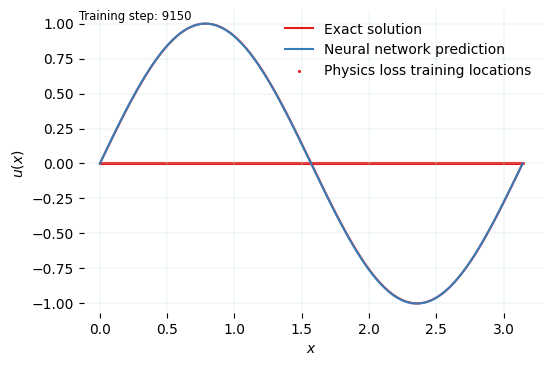

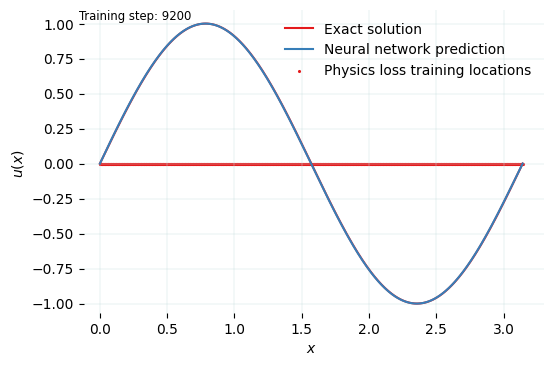

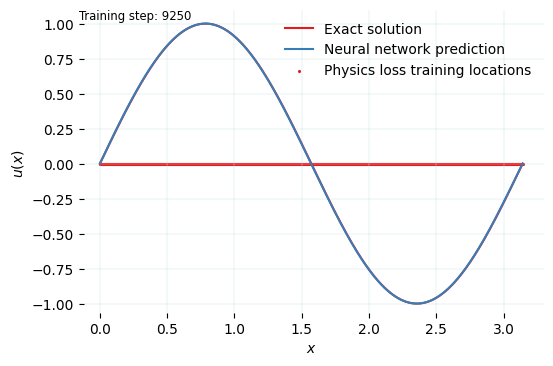

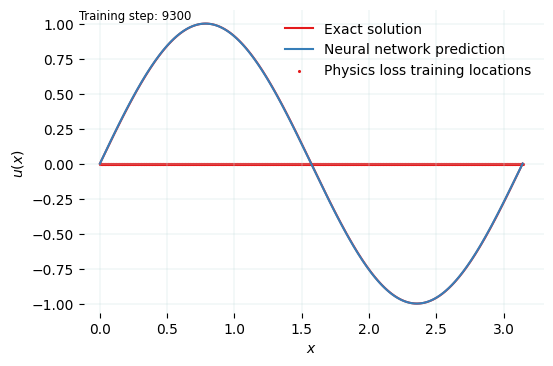

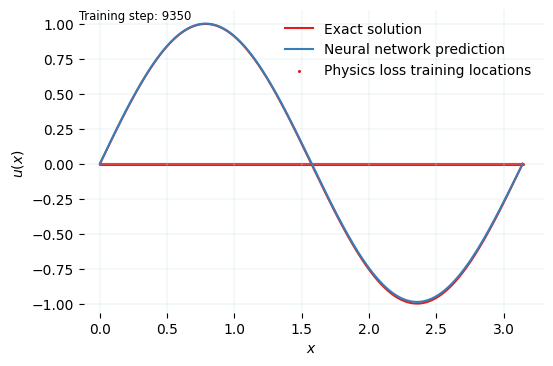

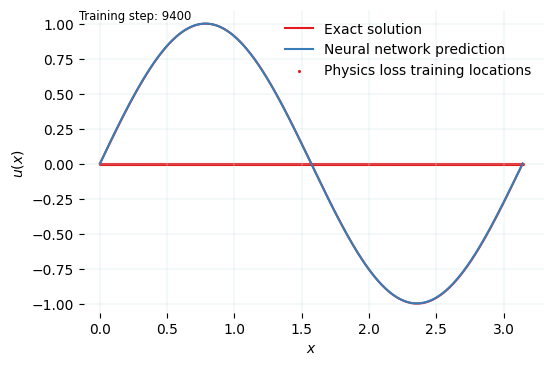

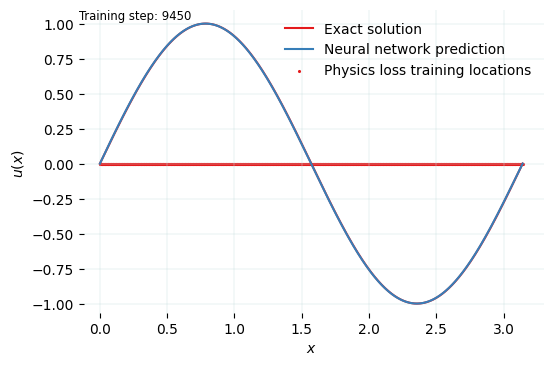

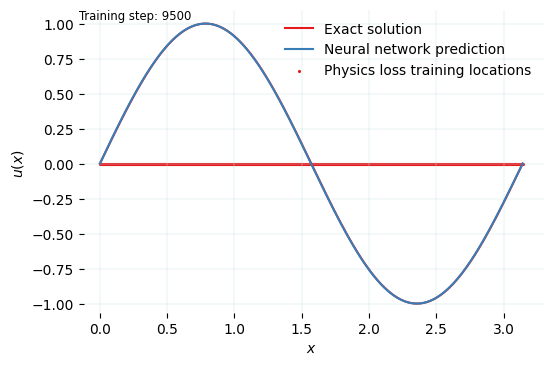

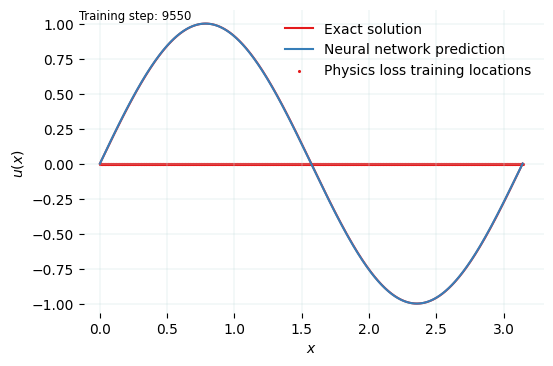

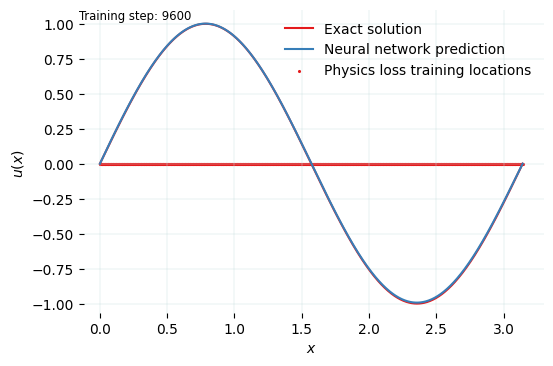

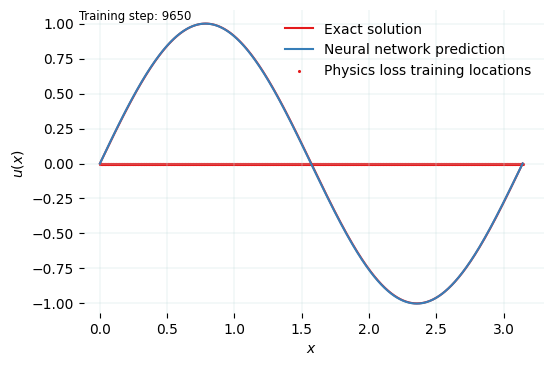

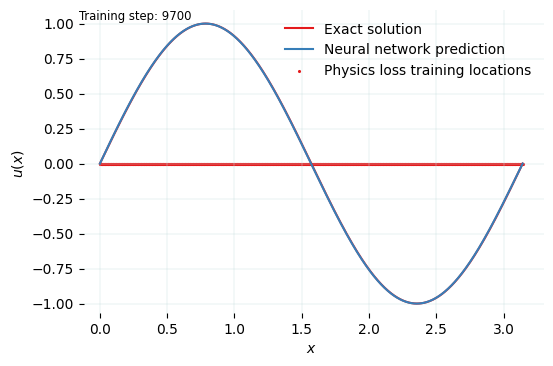

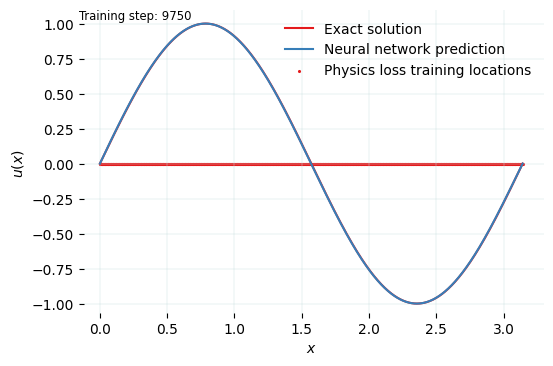

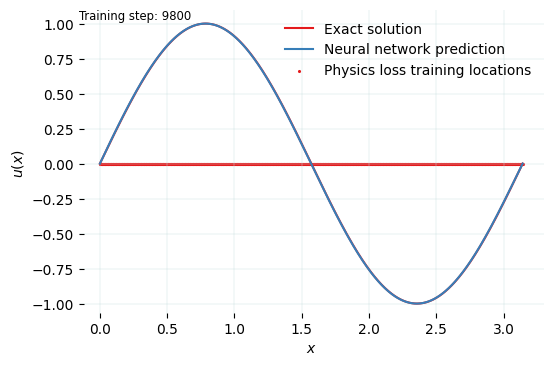

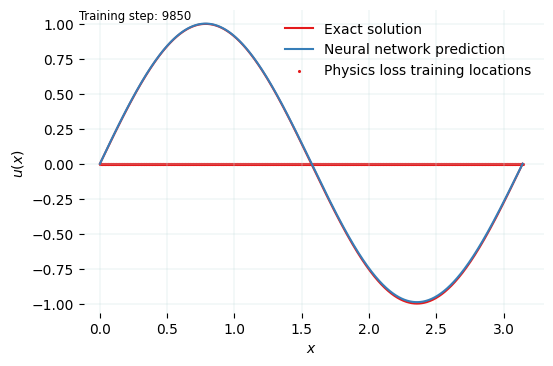

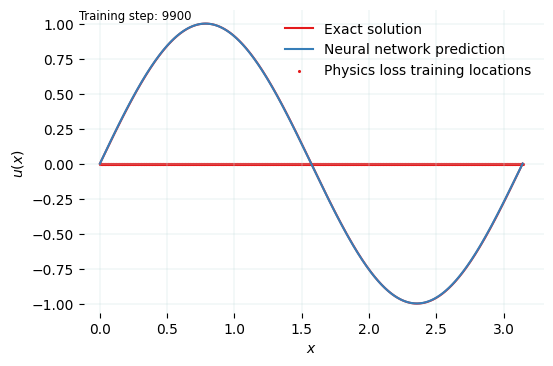

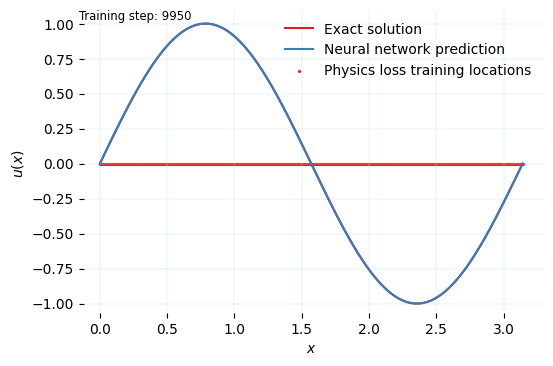

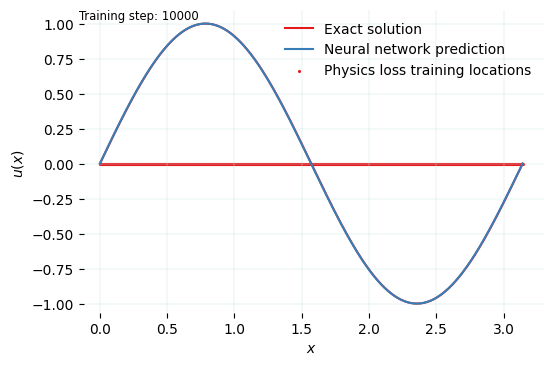

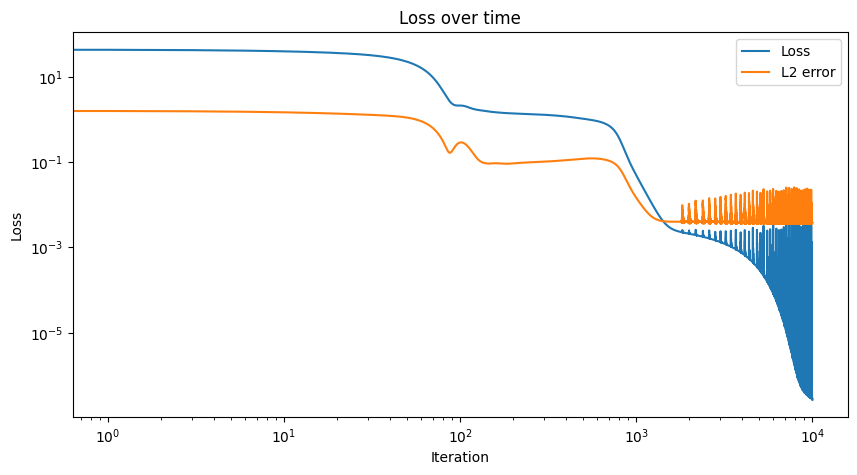

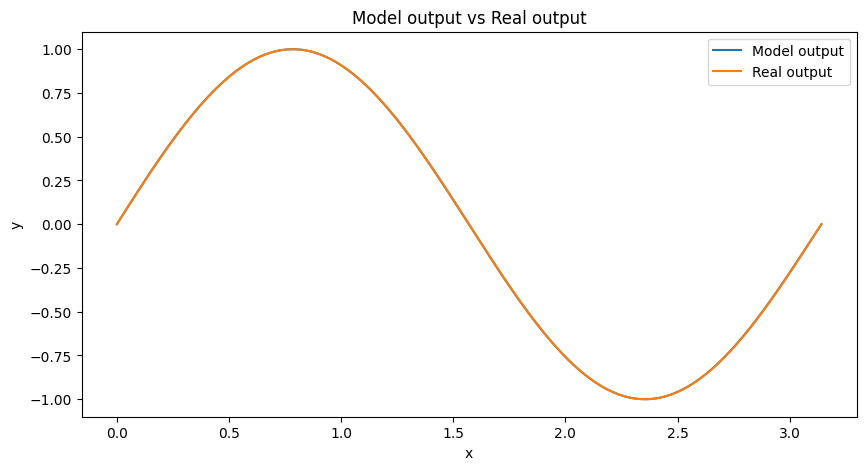

In [14]:
def compute_integral(y, x):    
    integral = torch.trapz(y, x, dim=0)
    return integral
 
def compute_loss(model, x, v, v_dv):
    u = model(x)
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0] 
    
    #dvs = list()
    #for mode in v.T:
    #    dv = torch.autograd.grad(mode.sum(), x, create_graph=True)[0]
    #    dvs.append(dv)        
    #dvs = torch.stack(dvs)
    
    dvs = v_dv
        
    f_rhs_val = f_rhs(x)    
    #integral_left = compute_integral(torch.einsum('jl,kjl->jk', du, dvs),x)    BUENO SINS FUNCS
    integral_left = compute_integral(torch.einsum('ij,ij->ij', du, dvs), x) # PRUEBA HELMHOLTZ
    integral_right = compute_integral(torch.einsum('jl,jk->jk', f_rhs_val, v), x)

    error_PDE = (integral_left - integral_right)**2    
    loss = error_PDE.sum()

    return loss

def compute_L2_error(model, x, exact_u):
    exact_function = exact_u(x)
    predicted_function = model(x).detach()

    error_between_arrays = (exact_function - predicted_function)**2
    L2_error = compute_integral(error_between_arrays, x)

    return torch.sqrt(L2_error).item()

def main():
    N_modes = 20
    n_pts = 1000
    iterations = 10000

    torch.manual_seed(123)
    model = FCN(1, 1, 10, 4)    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    L2_errors = []     

    n = torch.linspace(1, N_modes, N_modes)     

    for i in range(iterations):

        #random_points = torch.rand(n_pts)        
        #x = torch.sort(random_points * torch.pi)[0]
        x = torch.linspace(0, np.pi, n_pts)
        
        # Funciones de test - vectores propios Helmholtz        
        v_test = torch.zeros(n_pts, N_modes)
        v_dv = torch.zeros(n_pts, N_modes)
        for j in range(vecs_comp.shape[1]):
            spline_mode = UnivariateSpline(x, vecs_comp[:, j], s=0, k=1)
            v_mode = spline_mode(x)  
            v_mode = v_mode.reshape(n_pts, 1)              
            v_test[:, j] = torch.tensor(v_mode).squeeze()
            v_dv[:, j] = torch.tensor(spline_mode.derivative()(x)).squeeze()            

        x = x.requires_grad_(True).view(n_pts, 1)   
        
        # Funciones test sin funcs
        #v = torch.sin(torch.einsum('jk,i->ji', x, n))         
        
        v = v_test
        dvs = v_dv
    
        optimizer.zero_grad()

        loss = compute_loss(model, x, v, dvs)
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        L2_errors.append(compute_L2_error(model, x, exact_u))
        if (i+1) % 50 == 0:
            print(f"Loss at iteration {i+1}: {loss.item():.15f}")  
               
            x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
            y_test = model(x_test).detach().numpy()    
            y_real = exact_u(x_test).detach().numpy() 
            style_plot(x_test, y_real, x_data=None, y_data=None, yh=y_test, i=i, xp=x_test)       

    plt.figure(figsize=(10, 5))
    plt.loglog(losses, label='Loss')
    plt.loglog(L2_errors, label='L2 error')
    plt.title('Loss over time')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
    y_test = model(x_test).detach().numpy()    
    y_real = exact_u(x_test).detach().numpy()  

    plt.figure(figsize=(10, 5))
    plt.plot(x_test.numpy(), y_test, label='Model output')
    plt.plot(x_test.numpy(), y_real, label='Real output')
    plt.title('Model output vs Real output')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()    

if __name__ == "__main__":
    main()

In [15]:
n = torch.arange(1, 1000 + 1).float()
test_funcs = lambda x: torch.sin(torch.pi * n.view(-1, 1) * x)
v = test_funcs(x)
v

tensor([[ 0.0000e+00,  3.1447e-03,  6.2894e-03,  ...,  6.2893e-03,
          3.1446e-03, -8.7423e-08],
        [ 0.0000e+00,  6.2894e-03,  1.2579e-02,  ..., -1.2578e-02,
         -6.2893e-03,  1.7485e-07],
        [ 0.0000e+00,  9.4341e-03,  1.8867e-02,  ...,  1.8867e-02,
          9.4340e-03, -2.3850e-08],
        ...,
        [ 0.0000e+00,  3.1446e-03, -6.2892e-03,  ...,  6.3913e-03,
         -3.2467e-03,  1.0203e-04],
        [ 0.0000e+00, -1.1105e-07,  2.2210e-07,  ..., -1.1072e-04,
          1.1083e-04, -1.1094e-04],
        [ 0.0000e+00, -3.1449e-03,  6.2897e-03,  ..., -6.1698e-03,
          3.0250e-03,  1.1985e-04]], dtype=torch.float64)